<a href="https://colab.research.google.com/github/BonoGiorgio02/6DPose_Estimation/blob/saves/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6D Pose Estimation

## Set up the project

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/6D_pose_estimation/

/content/drive/.shortcut-targets-by-id/1clSdIvJJw8QuywtOyjjWKwogqb-DdNZh/6D_pose_estimation


In [3]:
path = !pwd
path = path[0]
print(path)

/content/drive/.shortcut-targets-by-id/1clSdIvJJw8QuywtOyjjWKwogqb-DdNZh/6D_pose_estimation


In [4]:
# PRIMO BLOCCO - Solo installazioni (senza import!)
%%capture
import os
import torch
os.environ['TORCH'] = torch.__version__

# Installa PRIMA tutte le dipendenze PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-spline-conv -f https://data.pyg.org/whl/torch-${TORCH}.html

# Installa PyTorch Geometric
!pip install torch-geometric

# Installa le altre dipendenze
!pip install matplotlib seaborn scikit-learn pyyaml plotly open3d Pillow ultralytics wandb numpy-quaternion trimesh

print("Installazione completata! RIAVVIA IL RUNTIME prima di procedere.")

In [5]:
import os
import yaml
import torch
import torchvision
import open3d as o3d
import itertools
import shutil
from torch.utils.data import Dataset
from torch import nn, optim
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import wandb
from scipy.spatial.transform import Rotation as R
from torchvision import models
import cv2
from torch.optim import Adam
import quaternion
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
from ultralytics import YOLO
from torchvision.transforms import v2
import trimesh

# Import PyTorch Geometric DOPO l'installazione e il riavvio
import torch_geometric
from torch import Tensor
from torch_geometric.nn import knn_interpolate, MessagePassing
from torch_geometric.nn.pool import fps, radius

IMG_WIDTH = 640
IMG_HEIGHT = 480

# Test per verificare che tutto funzioni
try:
    from torch_geometric.nn.pool import fps
    print("✅ PyTorch Geometric installato correttamente!")
    print(f"PyTorch version: {torch.__version__}")
    print(f"PyTorch Geometric version: {torch_geometric.__version__}")
except ImportError as e:
    print(f"❌ Errore: {e}")
    print("Assicurati di aver riavviato il runtime dopo l'installazione.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ PyTorch Geometric installato correttamente!
PyTorch version: 2.6.0+cu124
PyTorch Geometric version: 2.6.1


In [6]:
# %%capture
# !pip install torch torchvision torchaudio matplotlib seaborn scikit-learn pyyaml plotly open3d pcl Pillow ultralytics wandb numpy-quaternion trimesh torch_geometric

In [7]:
# import os
# import yaml
# import torch
# import torchvision
# import open3d as o3d
# import itertools
# import shutil
# from torch.utils.data import Dataset
# from torch import nn, optim
# import torch.nn.functional as F
# from PIL import Image
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt
# import numpy as np
# import plotly.graph_objects as go
# from sklearn.model_selection import train_test_split
# from torch.utils.data import DataLoader
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# import wandb
# from scipy.spatial.transform import Rotation as R
# from torchvision import models
# import cv2
# from torch.optim import Adam
# import quaternion
# from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
# from tqdm import tqdm
# from torch.cuda.amp import GradScaler, autocast
# from ultralytics import YOLO
# from torchvision.transforms import v2
# import trimesh
# import torch_geometric
# from torch import Tensor
# from torch_geometric.nn import knn_interpolate, MessagePassing
# from torch_geometric.nn.pool import fps, radius

# IMG_WIDTH = 640
# IMG_HEIGHT = 480

In [8]:
# os.environ['TORCH'] = torch.__version__

In [9]:
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [10]:
if torch.cuda.is_available():
    print("Cuda")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("Cuda not available, use mps")
    device = torch.device("mps")
else:
    print("Use CPU")
    device = torch.device("cpu")

Cuda


In [11]:
os.makedirs("./wandb", exist_ok=True)
os.environ["WANDB_DIR"] = "./wandb"
wandb.login(key="f4df6e7de444f28d1b90bb727c18cc88ea498e4f")
wandb.init(project="6D_pose_estimation")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: claudiocamolese (claudiocamolese-politecnico-di-torino) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Download dataset

We will work with a portion of this dataset, which you can find here: https://drive.google.com/drive/folders/19ivHpaKm9dOrr12fzC8IDFczWRPFxho7

In [ ]:
# Step 1: Download the dataset (LineMOD)
# Download LineMOD dataset
# create directory structure without errors
# -p create directories only if they do not exist
!mkdir -p datasets/linemod/
%cd datasets/linemod/

In [ ]:
# Download DenseFusion Folder (Which includes a portion of the LimeMOD dataset)
!gdown --folder "https://drive.google.com/drive/folders/19ivHpaKm9dOrr12fzC8IDFczWRPFxho7"

In [ ]:
!mkdir -p DenseFusion/
%cd DenseFusion/

In [ ]:
!unzip Linemod_preprocessed.zip

Install requirements

In [ ]:
!pip install -r ../../../requirements.txt

Get working directory

In [ ]:
path = !pwd
path = path[0]

## Data Exploration

Load an image

In [ ]:
img_path = "./Linemod_preprocessed/data/02/rgb/0101.png"
img = Image.open(img_path).convert("RGB")
plt.imshow(img)
plt.show()

In [ ]:
class CustomDataset(Dataset): # used to load and preprocess data
    def __init__(self, dataset_root, split='train', train_ratio=0.7, seed=42):
        """
        Args:
            dataset_root (str): Path to the dataset directory.
            split (str): 'train', 'validation' or 'test'.
            train_ratio (float): Percentage of data used for training (default 70%).
            seed (int): Random seed for reproducibility.
        """
        self.dataset_root = dataset_root
        self.split = split
        self.train_ratio = train_ratio
        self.seed = seed

        # Get list of all samples (folder_id, sample_id)
        self.samples = self.get_all_samples()

        # Check if samples were found
        if not self.samples:
            raise ValueError(f"No samples found in {self.dataset_root}. Check the dataset path and structure.")

        # Split into training and validation+test sets
        labels = [el[0] for el in self.samples]
        self.train_samples, self.val_test_samples = train_test_split(
            self.samples, train_size=self.train_ratio, random_state=self.seed, stratify=labels
        )

        # split validation+test set (by default 30% of the original dataset) into validation and test sets
        labels = [el[0] for el in self.val_test_samples]
        self.val_samples, self.test_samples = train_test_split(self.val_test_samples, train_size=0.5, random_state=self.seed, stratify=labels)

        # Select the appropriate split
        if split == "train":
            self.samples = self.train_samples
        elif split == "validation":
            self.samples = self.val_samples
        else:
            self.samples = self.test_samples

        # Define image transformations
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])

    def get_samples_id(self):
        return self.samples

    def get_all_samples(self):
        """Retrieve the list of all available sample indices from all folders."""
        samples = []
        for folder_id in range(1, 16):  # Assuming folders are named 01 to 15
            folder_path = os.path.join(self.dataset_root, 'data', f"{folder_id:02d}", "rgb")
            #print(folder_path)
            if os.path.exists(folder_path):
                # get id of the images
                sample_ids = sorted([int(f.split('.')[0]) for f in os.listdir(folder_path) if f.endswith('.png')])
                samples.extend([(folder_id, sid) for sid in sample_ids])  # Store (folder_id, sample_id)
        return samples

    def load_config(self, folder_id):
        """Load YAML configuration files for camera intrinsics and object info for a specific folder."""
        camera_intrinsics_path = os.path.join(self.dataset_root, 'data', f"{folder_id:02d}", 'info.yml')
        objects_info_path = os.path.join(self.dataset_root, 'models', f"models_info.yml")

        with open(camera_intrinsics_path, 'r') as f:
            camera_intrinsics = yaml.load(f, Loader=yaml.FullLoader)

        with open(objects_info_path, 'r') as f:
            objects_info = yaml.load(f, Loader=yaml.FullLoader)

        return camera_intrinsics, objects_info

    #Define here some usefull functions to access the data
    def load_image(self, img_path):
        """Load an RGB image and convert to tensor."""
        img = Image.open(img_path).convert("RGB")
        return self.transform(img)

    def load_depth(self, depth_path):
        """Load a depth image and convert to tensor."""
        depth = np.array(Image.open(depth_path))
        return torch.tensor(depth, dtype=torch.float32)

    def load_point_cloud(self, depth, intrinsics):
        """Convert depth image to point cloud using Open3D."""
        intrinsics = intrinsics[0]['cam_K'] # take intrinsincs of the first image
        h, w = depth.shape
        # focal lengths and principal centers
        fx, fy, cx, cy = intrinsics[0], intrinsics[4], intrinsics[2], intrinsics[5]

        # Generate 3D points
        xmap, ymap = np.meshgrid(np.arange(w), np.arange(h))
        z = depth / 1000.0  # Convert to meters
        x = (xmap - cx) * z / fx
        y = (ymap - cy) * z / fy

        points = np.stack((x, y, z), axis=-1).reshape(-1, 3)
        point_cloud = o3d.geometry.PointCloud()
        point_cloud.points = o3d.utility.Vector3dVector(points)

        return point_cloud

    def load_6d_pose(self, folder_id, sample_id):
        """Load the 6D pose (translation and rotation) for the object in this sample."""
        pose_file = os.path.join(self.dataset_root, 'data', f"{folder_id:02d}", "gt.yml")

        # Load the ground truth poses from the gt.yml file
        with open(pose_file, 'r') as f:
            pose_data = yaml.load(f, Loader=yaml.FullLoader)

        # The pose data is a dictionary where each key corresponds to a frame with pose info
        # We assume sample_id corresponds to the key in pose_data
        if sample_id not in pose_data:
            raise KeyError(f"Sample ID {sample_id} not found in gt.yml for folder {folder_id}.")

        for pose in pose_data[sample_id]: # There can be more than one pose per sample, but take the one of label=folder_id
            # Extract translation and rotation
            if (int(pose['obj_id']) == int(folder_id)):
                translation = np.array(pose['cam_t_m2c'], dtype=np.float32)  # [3] ---> (x,y,z)
                rotation = np.array(pose['cam_R_m2c'], dtype=np.float32).reshape(3, 3)  # [3x3] ---> rotation matrix
                # bbox is top left corner and width and height info, YOLO needs center coordinates and width and height
                x_min, y_min, width, height = np.array(pose['obj_bb'], dtype=np.float32) # [4] ---> x_min, y_min, width, height
                # Compute initial center
                x_center = x_min + width / 2
                y_center = y_min + height / 2

                # Clip center to image bounds and adjust width/height accordingly
                if x_center < 0:
                    width += 2 * x_center  # x_center is negative, subtract its absolute value * 2 from width
                    x_center = 0
                elif x_center > IMG_WIDTH:
                    width -= 2 * (x_center - IMG_WIDTH)
                    x_center = IMG_WIDTH

                # if y_center<0 take the max(0,y_center), if y_center>IMG_WIDTH take min(IMG_WIDTH, y_center)
                if y_center < 0:
                    height += 2 * y_center
                    y_center = 0
                elif y_center > IMG_HEIGHT:
                    height -= 2 * (y_center - IMG_HEIGHT)
                    y_center = IMG_HEIGHT

                # Ensure width and height are not negative
                # Caso in cui la bounding box sia completamente al di fuori dell'immagine (non dovrebbe mai capitare)
                width = max(0, width)
                height = max(0, height)
                # store coordinates of the center and width and height of the bounding box normalized to the
                # image width=640 pixels and height=480 pixels
                bbox = np.array([x_center/IMG_WIDTH, y_center/IMG_HEIGHT, width/IMG_WIDTH, height/IMG_HEIGHT], dtype=np.float32)

                obj_id = np.array(pose['obj_id'], dtype=np.float32) # [1] ---> label
                break

        return translation, rotation, bbox, obj_id

    def __len__(self):
        #Return the total number of samples in the selected split.
        return len(self.samples)

    def __getitem__(self, idx):
        #Load a dataset sample.
        folder_id, sample_id = self.samples[idx]

        # Load the correct camera intrinsics and object info for this folder
        camera_intrinsics, objects_info = self.load_config(folder_id)

        img_path = os.path.join(self.dataset_root, 'data', f"{folder_id:02d}", f"rgb/{sample_id:04d}.png")
        depth_path = os.path.join(self.dataset_root, 'data', f"{folder_id:02d}", f"depth/{sample_id:04d}.png")

        img = self.load_image(img_path)
        depth = self.load_depth(depth_path)
        point_cloud = self.load_point_cloud(depth.numpy(), camera_intrinsics)
        point_cloud = torch.tensor(np.asarray(point_cloud.points), dtype=torch.float32)
        translation, rotation, bbox, obj_id = self.load_6d_pose(folder_id, sample_id)

        #Dictionary with all the data
        return {
            "rgb": img,
            "depth": torch.tensor(depth, dtype=torch.float32),
            "point_cloud": point_cloud,
            "camera_intrinsics": camera_intrinsics[0]['cam_K'],
            "objects_info": objects_info,
            "translation": torch.tensor(translation),
            "rotation": torch.tensor(rotation),
            "bbox": torch.tensor(bbox),
            "obj_id": torch.tensor(obj_id),
        }

In [ ]:
dataset_root = "./Linemod_preprocessed/"

train_dataset = CustomDataset(dataset_root, split="train")
print(f"Training samples: {len(train_dataset)}")

val_dataset = CustomDataset(dataset_root, split="validation")
print(f"Validation samples: {len(val_dataset)}")

test_dataset = CustomDataset(dataset_root, split="test")
print(f"Testing samples: {len(test_dataset)}")

### Visualization 2D - 3D - 2D con y e y ribaltata

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

depth_path = r'.\\datasets\\linemod\\DenseFusion\\Linemod_preprocessed\\data\\01\\depth\\0000.png'
mask_path = r'.\\datasets\\linemod\\DenseFusion\\Linemod_preprocessed\\data\\01\\mask\\0000.png'

# Parametri intrinseci della camera LineMOD (dai tuoi dati)
fx = 572.4114  # focal length x
fy = 573.57043  # focal length y
cx = 325.2611  # principal point x
cy = 242.04899  # principal point y

# Carica la depth map come immagine a 16 bit
depth_img = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)  # mantiene dtype uint16
mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
mask_binary = mask_img != 0

masked_depth = np.where(mask_binary, depth_img, 0)

print("Shape:", depth_img.shape)
print("Dtype:", depth_img.dtype)
print("Min depth:", np.min(depth_img))
print("Max depth:", np.max(depth_img))
print("Pixels = 0:", np.sum(depth_img == 0))
print("Total pixels:", 480*640)

def pixel_to_camera_coordinates(masked_depth, fx, fy, cx, cy):
    """
    Converte coordinate pixel + depth in coordinate metriche 3D usando i parametri intrinseci

    Formula di conversione:
    X = (u - cx) * Z / fx
    Y = (v - cy) * Z / fy
    Z = depth

    dove (u,v) sono coordinate pixel e Z è la profondità
    """
    height, width = masked_depth.shape

    # Trova tutti i pixel con profondità valida (non zero)
    valid_mask = masked_depth > 0

    # Crea griglia di coordinate pixel
    u, v = np.meshgrid(np.arange(width), np.arange(height))

    # Estrai coordinate dei pixel validi
    u_valid = u[valid_mask]  # coordinate u (pixel)
    v_valid = v[valid_mask]  # coordinate v (pixel)
    z_valid = masked_depth[valid_mask].astype(np.float32) / 1000.0  # profondità in metri

    # Conversione da coordinate pixel a coordinate camera (tutte in metri)
    x_meters = (u_valid - cx) * z_valid / fx
    y_meters = (v_valid - cy) * z_valid / fy
    z_meters = z_valid

    return x_meters, y_meters, z_meters, u_valid, v_valid

# Crea la point cloud 3D in coordinate metriche
x_meters, y_meters, z_meters, u_pixels, v_pixels = pixel_to_camera_coordinates(masked_depth, fx, fy, cx, cy)

print(f"\n=== Point Cloud 3D Info (Coordinate Metriche) ===")
print(f"Numero di punti validi: {len(x_meters)}")
print(f"Range X (metri): {x_meters.min():.3f} - {x_meters.max():.3f}")
print(f"Range Y (metri): {y_meters.min():.3f} - {y_meters.max():.3f}")
print(f"Range Z (metri): {z_meters.min():.3f} - {z_meters.max():.3f}")

print(f"\n=== Parametri Camera ===")
print(f"fx: {fx}, fy: {fy}")
print(f"cx: {cx}, cy: {cy}")
print(f"Dimensioni immagine: {masked_depth.shape[1]}x{masked_depth.shape[0]} pixel")

# === Visualizzazione Comparativa ===
fig = plt.figure(figsize=(12, 8))

# Immagine depth originale
plt.subplot(2, 2, 1)
plt.title("Depth Original", fontsize=12)
plt.imshow(depth_img, cmap='gray')
plt.colorbar(label='Depth (mm)')
plt.xlabel('X (pixel)')
plt.ylabel('Y (pixel)')

# Masked Depth
plt.subplot(2, 2, 2)
plt.title("Masked Depth", fontsize=12)
plt.imshow(masked_depth, cmap='gray')
plt.colorbar(label='Depth (mm)')
plt.xlabel('X (pixel)')
plt.ylabel('Y (pixel)')

# Distribuzione punti in coordinate pixel (per confronto)
plt.subplot(2, 2, 3)
plt.title("Point Distribution (Pixel Coords)", fontsize=12)
scatter_pixel = plt.scatter(u_pixels, v_pixels, c=z_meters, cmap='viridis', s=6, alpha=0.6)
plt.colorbar(scatter_pixel, label='Depth (m)')
plt.xlabel('X (pixel)')
plt.ylabel('Y (pixel)')
plt.gca().invert_yaxis()

# === COORDINATE METRICHE (LA PARTE IMPORTANTE) ===

# Plot 3D principale - COORDINATE METRICHE
ax1 = fig.add_subplot(2, 2, 4, projection='3d')
ax1.set_title("3D Point Cloud\n(X,Y,Z tutti in metri)", fontsize=12)
scatter3d = ax1.scatter(x_meters, y_meters, z_meters, c=z_meters, cmap='plasma', s=1, alpha=0.7)
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_zlabel('Z (m)')
plt.colorbar(scatter3d, ax=ax1, shrink=0.5, aspect=5, label='Depth (m)')

plt.tight_layout()
plt.show()

# === Visualizzazione 3D dettagliata con coordinate metriche ===
fig = plt.figure(figsize=(16, 12))

# Plot 3D con diversi angoli di vista
angles = [(30, 45), (60, 30), (0, 0), (90, 90)]
titles = ["3D View (30°, 45°)", "3D View (60°, 30°)", "Front View (X-Y)", "Top View (X-Z)"]

for i, (elev, azim) in enumerate(angles):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    scatter = ax.scatter(x_meters, y_meters, z_meters, c=z_meters, cmap='plasma', s=0.8, alpha=0.7)
    ax.set_title(f"{titles[i]} - Metric Coordinates", fontsize=12)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.view_init(elev=elev, azim=azim)

    if i == 0:  # Aggiungi colorbar solo al primo plot
        plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='Depth (m)')

plt.tight_layout()
plt.show()

# === Salva i dati ===
# Salva la point cloud in coordinate metriche
point_cloud_metric = np.column_stack((x_meters, y_meters, z_meters))
point_cloud_pixel = np.column_stack((u_pixels, v_pixels, z_meters))

np.save('masked_depth_3d_metric_coords.npy', point_cloud_metric)
np.save('masked_depth_3d_pixel_coords.npy', point_cloud_pixel)

print(f"\n=== Salvataggio ===")
print(f"Point cloud METRICA salvata in 'masked_depth_3d_metric_coords.npy'")
print(f"Point cloud PIXEL salvata in 'masked_depth_3d_pixel_coords.npy'")
print(f"Shape metrica: {point_cloud_metric.shape}")
print(f"Shape pixel: {point_cloud_pixel.shape}")
print(f"Formato metrico: [x_metri, y_metri, z_metri]")
print(f"Formato pixel: [x_pixel, y_pixel, z_metri]")

# Mostra alcuni esempi di punti
print(f"\nPrimi 10 punti (COORDINATE METRICHE):")
print(f"[X_m, Y_m, Z_m]")
for i in range(min(10, len(point_cloud_metric))):
    x, y, z = point_cloud_metric[i]
    print(f"[{x:+.3f}, {y:+.3f}, {z:.3f}]")

print(f"\nPrimi 10 punti (COORDINATE PIXEL + Z metri):")
print(f"[X_px, Y_px, Z_m]")
for i in range(min(10, len(point_cloud_pixel))):
    x, y, z = point_cloud_pixel[i]
    print(f"[{x:3.0f}, {y:3.0f}, {z:.3f}]")

# Calcola e mostra il centroide dell'oggetto
centroid = np.mean(point_cloud_metric, axis=0)
print(f"\nCentroide dell'oggetto (coordinate metriche):")
print(f"X: {centroid[0]:.3f} m")
print(f"Y: {centroid[1]:.3f} m")

In [ ]:
# Carica la point cloud in coordinate metriche
# Se hai già salvato la point cloud
# point_cloud_metric = np.load('masked_depth_3d_metric_coords.npy')

# Altrimenti puoi usare direttamente x_meters, y_meters, z_meters
point_cloud_metric = np.column_stack((x_meters, y_meters, z_meters))

# Crea un oggetto PointCloud di open3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud_metric)

# (Opzionale) Aggiungi colore in base alla profondità (Z)
colors = (z_meters - z_meters.min()) / (z_meters.max() - z_meters.min())
colors = plt.cm.plasma(colors)[:, :3]  # Usa colormap matplotlib, prendi solo RGB
pcd.colors = o3d.utility.Vector3dVector(colors)

# Visualizza la point cloud con viewer 3D interattivo
o3d.visualization.draw_geometries([pcd], window_name="3D Point Cloud")

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

depth_path = r'.\\datasets\\linemod\\DenseFusion\\Linemod_preprocessed\\data\\01\\depth\\0000.png'
rgb_path = r'.\\datasets\\linemod\\DenseFusion\\Linemod_preprocessed\\data\\01\\rgb\\0000.png'
mask_path = r'.\\datasets\\linemod\\DenseFusion\\Linemod_preprocessed\\data\\01\\mask\\0000.png'

# === Carica dati ===
# (Modifica il path per caricare la tua immagine e profondità)
rgb = cv2.imread(rgb_path)
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED).astype(np.float32) / 1000.0  # in metri
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Carica parametri intrinseci della camera
fx, fy = 572.4114, 573.57043
cx, cy = 325.2611, 242.04899

# === Estrai pixel validi ===
v, u = np.where(mask > 0)
z = depth[v, u]
x = (u - cx) * z / fx
y = (v - cy) * z / fy

# === Point cloud senza inversione Y ===
pc_natural = np.column_stack((x, y, z))

# === Point cloud con inversione Y ===
y_inv = -y
pc_inverted = np.column_stack((x, y_inv, z))

# === Proiezione 3D -> 2D ===
def project_to_2d(x, y, z):
    u_proj = (x * fx) / z + cx
    v_proj = (y * fy) / z + cy
    return u_proj, v_proj

u_nat, v_nat = project_to_2d(pc_natural[:,0], pc_natural[:,1], pc_natural[:,2])
u_inv, v_inv = project_to_2d(pc_inverted[:,0], pc_inverted[:,1], pc_inverted[:,2])

# === Visualizza i risultati ===
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# Immagine originale
axs[0].imshow(rgb)
axs[0].set_title('Immagine RGB Originale')
axs[0].axis('off')

# Proiezione senza inversione
axs[1].imshow(rgb)
axs[1].scatter(u_nat, v_nat, s=1, c='red')
axs[1].set_title('Proiezione senza inversione Y')
axs[1].axis('off')

# Proiezione con inversione Y
axs[2].imshow(rgb)
axs[2].scatter(u_inv, v_inv, s=1, c='blue')
axs[2].set_title('Proiezione con inversione Y')
axs[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
root_path = r'.\\datasets\\linemod\\DenseFusion\\Linemod_preprocessed\\data'

def extract_cam_K_from_info(info):
    # info è un dict con chiavi come '0', '1', ... ciascuna con un dict che contiene 'cam_K'
    cam_K_list = []
    for key, val in info.items():
        if "cam_K" in val:
            cam_K_list.append(val["cam_K"])
    return cam_K_list

all_cam_Ks = []  # lista di tutte le cam_K trovate in tutti i file

for obj_class in sorted(os.listdir(root_path)):
    class_path = os.path.join(root_path, obj_class)
    if not os.path.isdir(class_path):
        continue

    info_path = os.path.join(class_path, "info.yml")
    if not os.path.exists(info_path):
        continue

    with open(info_path, 'r') as f:
        info = yaml.safe_load(f)

    cam_Ks = extract_cam_K_from_info(info)
    if len(cam_Ks) == 0:
        print(f"[Warning] Nessun cam_K trovato in {obj_class}/info.yml")
        continue

    # Aggiungi tutti i cam_K di questo file alla lista globale
    all_cam_Ks.extend(cam_Ks)

# Ora controlla che tutti i cam_K siano identici
if len(all_cam_Ks) == 0:
    print("Nessun cam_K trovato in nessun file.")
else:
    first_cam_K = all_cam_Ks[0]
    all_equal = all(cam_K == first_cam_K for cam_K in all_cam_Ks)

    if all_equal:
        print("Tutti i cam_K sono uguali in tutti i file info.yml")
    else:
        print("Ci sono cam_K diversi tra i file info.yml")

## Data Preprocessing

Structure the data such that
```
datasets/
├── data.yaml
│
├── train/
│   ├── images/
│   │
│   └── labels/
│  
├── val/
│
└── test/
```

In [ ]:
# divide the dataset into training, validation and testing set
train_samples = train_dataset.get_samples_id()
validation_samples = val_dataset.get_samples_id()
test_samples = test_dataset.get_samples_id() # test folder is optional for training YOLO

Create a new folder containing all the info, we just need the rgb image and a text file with the label and bounding box.
The ```Linemod_preprocessed``` is not removed, as it contains info about translation and rotation that are needed for pose estimation, but not for object detection model.

The working directory is in the ```DenseFusion```

In [ ]:
# create a folder to contain the dataset for YOLO model
os.makedirs("./datasets/linemod/YOLO/datasets", exist_ok=True)

# count number of distinct classes
number_classes = 0
class_names = []
for el in os.scandir("./datasets/linemod/DenseFusion/Linemod_preprocessed/data"):
    # if entry is a directory and its name is an integer value (this is just to avoid counting non directories or other directories)
    if (el.is_dir() and el.name.isdigit()):
        class_names.append(el.name)
        number_classes += 1

# get string of all class names
class_names.sort() # sort the names
names = "["
for index, el in enumerate(class_names):
    # if last element don't add comma
    if index == number_classes-1:
        names += f"'{str(el)}'"
    else:
        names += f"'{str(el)}',"
names += "]"

# create data.yaml (as class names use ids of the folder)
content = f"""train: ./train/images
val: ./val/images
test: ./test/images

nc: {number_classes}
names: {names}"""
# write to file
with open("./datasets/linemod/YOLO/datasets/data.yaml", "w") as fout:
    fout.write(content)
fout.close()

While creating the folder structure, we have to change the class id by using the index in the array written in the ```data.yaml```

In [ ]:
# create a dictionary to have easily access to the index
index_dict = dict()
for index, el in enumerate(class_names):
    index_dict[int(el)] = index

Create the folders. Note that each image may contain multiple objects. For instance in ```data/02/gt.yml``` for one image there are multiple objects

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os

# create images and labels
# dataset = [train_samples, validation_samples, test_samples]
folder_names = ["train", "val", "test"]

# count also the number of instances of each class
classes = range(0, number_classes)
counter_df = pd.DataFrame()
for idx in range(3):
    if idx == 0:
        dataset = train_samples
    elif idx == 1:
        dataset = validation_samples
    else:
        dataset = test_samples
    print(f"------------------------------{folder_names[idx].upper()}------------------------------")
    os.makedirs(f"../YOLO/datasets/{folder_names[idx]}/images", exist_ok=True)
    os.makedirs(f"../YOLO/datasets/{folder_names[idx]}/labels", exist_ok=True)
    classCount = {temp_class: 0 for temp_class in range(0,number_classes)} # initialize dictionary for counting
    total = 0 # used to normalize count
    for el in tqdm(dataset, desc="Moving..."):
        if int(el[0]) == 2:
            # el is (folderId, sampleId)
            _, _, bbox, obj_id = train_dataset.load_6d_pose(el[0], el[1])
            # copy image into the new folder
            # avoid overwriting the files, so concat also the name of the folderId to the destination file
            shutil.copy(f"./Linemod_preprocessed/data/{el[0]:02d}/rgb/{el[1]:04d}.png", f"../YOLO/datasets/{folder_names[idx]}/images/{el[0]:02d}_{el[1]:04d}.png")
            # create label file with the same name as the image
            with open(f"../YOLO/datasets/{folder_names[idx]}/labels/{el[0]:02d}_{el[1]:04d}.txt", "w") as fout:
                # bbox is a list of values in the form of [x_center, y_center, width, height] and obj_id a list of class labels
                # where each label is in the format 01-15
                content = ""
                classCount[index_dict[int(obj_id)]] += 1
                total += 1
                content += f"{index_dict[int(obj_id)]} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n"
                fout.write(content)
            fout.close()

    # store in the dataframe
    values = pd.array(list(classCount.values()))/total
    counter_df[folder_names[idx]] = values.copy()

# plot distribution of labels in training, validation and test set
plt.grid(alpha=0.5)
sns.lineplot(data=counter_df)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(range(0,number_classes))
plt.savefig(f"../../../images/YOLO_dataset_distribution.png")
plt.show()

### Visualize data

Visualize depth image

In [ ]:
img_path = "./Linemod_preprocessed/data/02/depth/0101.png"
img = Image.open(img_path)
plt.imshow(img)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Plot image with bounding box

# Load the ground truth poses from the gt.yml file
with open("./Linemod_preprocessed/data/02/gt.yml", 'r') as f:
  pose_data = yaml.load(f, Loader=yaml.FullLoader)
pose = pose_data[101][6] # access image 0 (start counting from 0) and get first object in that image (in case of multiple objects)

bbox = np.array(pose['obj_bb'], dtype=np.float32) #[4]
obj_id = np.array(pose['obj_id'], dtype=np.float32) #[1]

fig, ax = plt.subplots()
ax.imshow(img)

# Create a rectangle patch
rect = patches.Rectangle(
    (bbox[0], bbox[1]),  # (x, y)
    bbox[2],             # width
    bbox[3],             # height
    linewidth=2,
    edgecolor='red',
    facecolor='none'
)

# Add the rectangle to the plot
ax.add_patch(rect)

# Optionally add object ID label (write a bit above the top left corner)
ax.text(bbox[0], bbox[1] - 20, f'ID: {int(obj_id)}', color='yellow', fontsize=12, backgroundcolor='black')

plt.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Plot image with bounding box

# Load the ground truth poses from the gt.yml file
with open("../YOLO/datasets/val/labels/02_0101.txt", 'r') as f:
    lines = f.readlines()
    for line in lines:
        parts = line.split(" ")
        bbox = np.array(parts[1:5], dtype=np.float32) #[4]
        obj_id = np.array(parts[0], dtype=np.float32) #[1]
        if obj_id == 7.0:
            x_center, y_center, width, height = bbox[0:4]
            x_center = x_center*IMG_WIDTH
            y_center = y_center*IMG_HEIGHT
            width = width*IMG_WIDTH
            height = height*IMG_HEIGHT
            x_min = x_center-(width/2)
            y_min = y_center-(height/2)
            fig, ax = plt.subplots()
            ax.imshow(img)

            # Create a rectangle patch
            rect = patches.Rectangle(
                (x_min, y_min),  # (x, y)
                width,             # width
                height,             # height
                linewidth=2,
                edgecolor='red',
                facecolor='none'
            )

            # Add the rectangle to the plot
            ax.add_patch(rect)

            # Optionally add object ID label (write a bit above the top left corner)
            ax.text(x_min, y_min - 20, f'ID: {int(obj_id)}', color='yellow', fontsize=10, backgroundcolor='black')

    plt.axis('off')
    plt.show()

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
print(f"Training loader: {len(train_loader)}")
print(f"Validation loader: {len(val_loader)}")
print(f"Test loader: {len(test_loader)}")

In [ ]:
import itertools

# Get only the first 1 batch
train_subset_num_batches = 1
val_subset_num_batches = 1
test_subset_num_batches = 1
train_subset = list(itertools.islice(train_loader, train_subset_num_batches))
val_subset = list(itertools.islice(val_loader, val_subset_num_batches))
test_subset = list(itertools.islice(test_loader, test_subset_num_batches))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Get one batch from the train loader (4 images)
batch = next(iter(train_loader)) # it uses load_6d_pose, so one pose per object

# Extract relevant data
rgb_images = batch["rgb"]         # (B, 3, H, W)
bboxes = batch["bbox"]            # (B, 4) in pixel coords: x_min, y_min, x_max, y_max
obj_ids = batch["obj_id"]         # (B,)

# Convert to numpy and rearrange channels
rgb_images = rgb_images.permute(0, 2, 3, 1).numpy()  # (B, H, W, 3)
bboxes = bboxes.numpy()
obj_ids = obj_ids.numpy()

# Plot settings
batch_size = rgb_images.shape[0]
cols = min(4, batch_size)
rows = (batch_size + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
axes = axes.flatten()

for i in range(batch_size):
    ax = axes[i]
    img = rgb_images[i]
    # each element is [x_center/IMG_WIDTH, y_center/IMG_HEIGHT, width/IMG_WIDTH, height/IMG_HEIGHT]
    x_center, y_center, width, height = bboxes[i]
    # remove normalization
    x_center = x_center*IMG_WIDTH
    y_center = y_center*IMG_HEIGHT
    width = width*IMG_WIDTH
    height = height*IMG_HEIGHT
    x_min = x_center-(width/2)
    y_min = y_center-(height/2)
    obj_id = obj_ids[i]

    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Sample {i}")

    # Draw bounding box
    rect = patches.Rectangle(
        (x_min, y_min),   # (x_min, y_min)
        width,              # width
        height,              # height
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )
    ax.add_patch(rect)

    # Add object ID as label
    ax.text(
        x_min,
        y_min - 10,
        f'ID: {int(obj_id)}',
        color='yellow',
        fontsize=10,
        backgroundcolor='black'
    )

# Hide unused axes if batch_size < cols * rows
for j in range(batch_size, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# !pwd
# %cd ../../test/labels

In [ ]:
# path = !pwd
# %cd datasets/linemod/YOLO/datasets/test/labels/

In [ ]:
# total = 0
# for l in os.listdir(path):
    # with open(l, 'r') as f:
        # lines = f.readlines()
        # for line in lines:
            # parts = line.split(" ")
            # x_center = parts[1]
            # y_center = parts[2]
            # if float(x_center) == 0.0 or float(y_center) == 0.0 or float(x_center) == 1.0 or float(y_center) == 1.0:
                # print(l)
                # total += 1
                # break
# print(total)

# Baseline

## Training Object Detection model

Check if CUDA available, otherwise try with MPS and then CPU

In [ ]:
# %cd ./drive/MyDrive/6D_pose_estimation/

/content/drive/.shortcut-targets-by-id/1clSdIvJJw8QuywtOyjjWKwogqb-DdNZh/6D_pose_estimation


In [ ]:
%cd ../../..

/content/drive/.shortcut-targets-by-id/1clSdIvJJw8QuywtOyjjWKwogqb-DdNZh/6D_pose_estimation


In [ ]:
old_path = !pwd
path = old_path[0]
path

'/content/drive/.shortcut-targets-by-id/1clSdIvJJw8QuywtOyjjWKwogqb-DdNZh/6D_pose_estimation'

In [ ]:
# Ricordarsi di cambiare il yaml e il percorso interno in base all'account in cui siete
# with open("./datasets/linemod/YOLO/datasets/data.yaml","r") as f:
  # f= f.read()
  # print(f)

train: ./train/images
val: ./val/images
test: ./test/images

nc: 13
names: ["01","02","04","05","06","08","09","10","11","12","13","14","15"]


## Training

In [ ]:
model_path = f"./checkpoints/yolo11n.pt"
model = YOLO(model_path)
epochs = 50
batch_size = 64
IMG_SIZE = 640

In [ ]:
# Devi essere in 6D
results = model.train(
        data=f"./datasets/linemod/YOLO/datasets/data.yaml",
        epochs=epochs,
        batch=batch_size,
        device=device,
        imgsz=IMG_SIZE,
        augment=True,
        flipud=0.5,
        fliplr=0.5,
        hsv_h=0.4,
        hsv_s=0.4,
        hsv_v=0.4,
        degrees=120,
        translate=0.1,
        scale=0.5,
        shear=20,
        perspective=0.0001,
        exist_ok=True,
        patience=5, #number of epoch to wait without improvement in validation metrics before early stopping the train. Helps prevent overfitting.
        dropout=0.3
        )

engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/.shortcut-targets-by-id/1clSdIvJJw8QuywtOyjjWKwogqb-DdNZh/6D_pose_estimation/YOLO/datasets/data.yaml, degrees=120, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.4, hsv_s=0.4, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=./checkpoints/yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0001, plots=True, pose

100%|██████████| 755k/755k [00:00<00:00, 14.4MB/s]

Overriding model.yaml nc=80 with nc=13

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

YOLO11n summary: 181 layers, 2,592,375 parameters, 2,592,359 gradients, 6.5 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 63.9±135.5 ms, read: 1.0±0.3 MB/s, size: 460.5 KB)


train: Scanning /content/drive/.shortcut-targets-by-id/1clSdIvJJw8QuywtOyjjWKwogqb-DdNZh/6D_pose_estimation/YOLO/datasets/train/labels... 11060 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11060/11060 [11:29<00:00, 16.04it/s]


train: New cache created: /content/drive/.shortcut-targets-by-id/1clSdIvJJw8QuywtOyjjWKwogqb-DdNZh/6D_pose_estimation/YOLO/datasets/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.7±0.0 ms, read: 1.7±0.2 MB/s, size: 437.8 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1clSdIvJJw8QuywtOyjjWKwogqb-DdNZh/6D_pose_estimation/YOLO/datasets/val/labels... 2370 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2370/2370 [02:19<00:00, 16.93it/s]


val: New cache created: /content/drive/.shortcut-targets-by-id/1clSdIvJJw8QuywtOyjjWKwogqb-DdNZh/6D_pose_estimation/YOLO/datasets/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      8.47G      1.754      4.115      1.589         97        640: 100%|██████████| 173/173 [01:07<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.59it/s]


                   all       2370       2370      0.757      0.734      0.837      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         9G      1.459       1.94      1.279        109        640: 100%|██████████| 173/173 [01:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.85it/s]

                   all       2370       2370      0.808      0.607      0.772      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         9G       1.39      1.396      1.243        109        640: 100%|██████████| 173/173 [01:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.77it/s]

                   all       2370       2370      0.837      0.799      0.906        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      9.02G      1.319      1.105      1.217        106        640: 100%|██████████| 173/173 [01:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.78it/s]

                   all       2370       2370      0.877      0.886      0.956      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      9.03G       1.24     0.9274      1.177        104        640: 100%|██████████| 173/173 [01:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.75it/s]

                   all       2370       2370       0.93      0.913      0.974      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      9.04G      1.181     0.8249      1.154         99        640: 100%|██████████| 173/173 [01:03<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.74it/s]

                   all       2370       2370      0.886      0.872      0.933      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      9.06G      1.139     0.7595       1.13         90        640: 100%|██████████| 173/173 [01:02<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.78it/s]

                   all       2370       2370      0.923      0.886      0.945      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      9.07G      1.113     0.7185      1.121         82        640: 100%|██████████| 173/173 [01:03<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.77it/s]

                   all       2370       2370      0.932      0.947      0.976      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      9.09G      1.077     0.6762      1.103         98        640: 100%|██████████| 173/173 [01:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.75it/s]

                   all       2370       2370      0.953      0.947      0.986      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       9.1G      1.069     0.6574        1.1         94        640: 100%|██████████| 173/173 [01:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.79it/s]

                   all       2370       2370       0.98      0.984      0.993      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      9.12G      1.053     0.6348      1.096        102        640: 100%|██████████| 173/173 [01:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.79it/s]

                   all       2370       2370      0.983      0.983      0.994      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      9.13G      1.031     0.6173      1.086         98        640: 100%|██████████| 173/173 [01:02<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.77it/s]

                   all       2370       2370      0.984      0.994      0.995      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      9.14G      1.001     0.5977      1.075        103        640: 100%|██████████| 173/173 [01:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.79it/s]

                   all       2370       2370      0.958      0.951      0.982      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      9.16G     0.9917     0.5876      1.065         99        640: 100%|██████████| 173/173 [01:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.77it/s]

                   all       2370       2370      0.982      0.977      0.994      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      9.17G     0.9726     0.5656      1.057         85        640: 100%|██████████| 173/173 [01:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.78it/s]

                   all       2370       2370      0.993      0.998      0.995      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      9.19G     0.9585     0.5554      1.055         94        640: 100%|██████████| 173/173 [01:02<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.79it/s]

                   all       2370       2370      0.995      0.999      0.995      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       9.2G      0.948     0.5401       1.05         99        640: 100%|██████████| 173/173 [01:02<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.78it/s]

                   all       2370       2370      0.996      0.991      0.994      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      9.22G     0.9377     0.5314      1.041         96        640: 100%|██████████| 173/173 [01:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.77it/s]

                   all       2370       2370      0.997      0.998      0.995      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      9.23G     0.9253     0.5251       1.04        107        640: 100%|██████████| 173/173 [01:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.76it/s]

                   all       2370       2370      0.997      0.999      0.995      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      9.25G      0.917     0.5204      1.038         86        640: 100%|██████████| 173/173 [01:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.80it/s]

                   all       2370       2370      0.997      0.994      0.995      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      9.26G     0.9023     0.5069      1.032         99        640: 100%|██████████| 173/173 [01:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.75it/s]

                   all       2370       2370      0.992      0.991      0.994      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      9.28G     0.8948     0.5002       1.03         91        640: 100%|██████████| 173/173 [01:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.81it/s]

                   all       2370       2370      0.998          1      0.995      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      9.29G     0.8811     0.4889      1.021        112        640: 100%|██████████| 173/173 [01:03<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.76it/s]

                   all       2370       2370      0.998          1      0.995      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      9.31G     0.8759     0.4842      1.018         91        640: 100%|██████████| 173/173 [01:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.78it/s]

                   all       2370       2370      0.998          1      0.995      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      9.32G     0.8671     0.4766      1.016         99        640: 100%|██████████| 173/173 [01:03<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.83it/s]

                   all       2370       2370      0.998      0.999      0.995      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      9.34G     0.8542     0.4717      1.012         96        640: 100%|██████████| 173/173 [01:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.79it/s]

                   all       2370       2370      0.999          1      0.995      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      9.35G     0.8429     0.4615      1.006         93        640: 100%|██████████| 173/173 [01:03<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.79it/s]

                   all       2370       2370      0.998          1      0.995      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      9.37G     0.8479     0.4665      1.007        106        640: 100%|██████████| 173/173 [01:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.78it/s]

                   all       2370       2370      0.999          1      0.995      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      9.38G     0.8277     0.4486     0.9996         96        640: 100%|██████████| 173/173 [01:02<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.76it/s]

                   all       2370       2370      0.999          1      0.995      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       9.4G     0.8186     0.4434     0.9975        104        640: 100%|██████████| 173/173 [01:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.75it/s]

                   all       2370       2370      0.998      0.999      0.995      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      9.41G     0.8114     0.4345     0.9916         92        640: 100%|██████████| 173/173 [01:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.78it/s]

                   all       2370       2370      0.999          1      0.995      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      9.43G     0.8091     0.4351     0.9912         95        640: 100%|██████████| 173/173 [01:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.78it/s]

                   all       2370       2370      0.999          1      0.995      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      9.44G     0.7949     0.4258     0.9888         83        640: 100%|██████████| 173/173 [01:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.83it/s]

                   all       2370       2370      0.999          1      0.995      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      9.46G     0.7917     0.4223     0.9855         99        640: 100%|██████████| 173/173 [01:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.75it/s]

                   all       2370       2370      0.999      0.999      0.995      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      9.47G     0.7828     0.4136     0.9833         93        640: 100%|██████████| 173/173 [01:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.75it/s]

                   all       2370       2370      0.999      0.999      0.995       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      9.48G      0.775     0.4121      0.979         98        640: 100%|██████████| 173/173 [01:03<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.79it/s]

                   all       2370       2370      0.999          1      0.995      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       9.5G      0.767     0.4033     0.9759        101        640: 100%|██████████| 173/173 [01:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.79it/s]

                   all       2370       2370      0.999          1      0.995      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.51G     0.7667     0.4092     0.9784        109        640: 100%|██████████| 173/173 [01:03<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.80it/s]

                   all       2370       2370      0.999          1      0.995      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      9.53G     0.7561     0.3988     0.9743         90        640: 100%|██████████| 173/173 [01:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.76it/s]

                   all       2370       2370      0.999          1      0.995      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      9.54G     0.7464     0.3908     0.9672         98        640: 100%|██████████| 173/173 [01:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.78it/s]

                   all       2370       2370      0.999          1      0.995      0.865


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      9.56G     0.6614     0.2729     0.9123         52        640: 100%|██████████| 173/173 [01:06<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.81it/s]

                   all       2370       2370      0.999          1      0.995      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      9.57G     0.6379     0.2625     0.9032         52        640: 100%|██████████| 173/173 [01:00<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.77it/s]

                   all       2370       2370      0.999          1      0.995      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      9.59G     0.6243     0.2587     0.8971         52        640: 100%|██████████| 173/173 [01:00<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.80it/s]

                   all       2370       2370      0.999          1      0.995       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       9.6G     0.6148     0.2548     0.8961         52        640: 100%|██████████| 173/173 [00:59<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.75it/s]

                   all       2370       2370      0.999          1      0.995       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      9.62G     0.6046     0.2488     0.8918         52        640: 100%|██████████| 173/173 [01:00<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.80it/s]

                   all       2370       2370      0.999          1      0.995      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      9.63G     0.5965     0.2446     0.8837         52        640: 100%|██████████| 173/173 [01:00<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.80it/s]

                   all       2370       2370      0.999          1      0.995      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      9.65G     0.5908     0.2416      0.883         52        640: 100%|██████████| 173/173 [01:00<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.79it/s]

                   all       2370       2370      0.999          1      0.995      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      9.66G     0.5816     0.2384     0.8791         52        640: 100%|██████████| 173/173 [01:00<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.79it/s]

                   all       2370       2370      0.999          1      0.995      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      9.68G     0.5717     0.2338      0.876         52        640: 100%|██████████| 173/173 [01:00<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.80it/s]

                   all       2370       2370      0.999          1      0.995      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      9.69G     0.5657     0.2314     0.8764         52        640: 100%|██████████| 173/173 [01:00<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.79it/s]

                   all       2370       2370      0.999          1      0.995      0.876



50 epochs completed in 1.022 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11n summary (fused): 100 layers, 2,584,687 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:13<00:00,  1.44it/s]


                   all       2370       2370      0.998          1      0.995      0.867
                    01        186        186      0.995          1      0.995      0.874
                    02        182        182      0.999          1      0.995      0.855
                    04        180        180      0.999          1      0.995      0.865
                    05        180        180      0.999          1      0.995      0.891
                    06        177        177      0.999          1      0.995      0.867
                    08        178        178          1          1      0.995      0.873
                    09        188        188      0.996          1      0.995      0.879
                    10        188        188      0.999          1      0.995       0.88
                    11        183        183      0.995      0.999      0.995      0.804
                    12        185        185      0.999          1      0.995      0.872
                    1

Copy model file to ```checkpoints```

In [ ]:
shutil.copy(f"./datasets/linemod/YOLO/runs/detect/train/weights/best.pt", f"./checkpoints/best.pt")

'/content/drive/.shortcut-targets-by-id/1clSdIvJJw8QuywtOyjjWKwogqb-DdNZh/6D_pose_estimation/checkpoints/best.pt'

## Testing best.pt

In [ ]:
from ultralytics import YOLO
model = YOLO(f"./checkpoints/best.pt")

In [ ]:
results = model.val(
        data=f"./datasets/linemod/YOLO/datasets/data.yaml",
        epochs=epochs,
        batch=batch_size,
        imgsz=IMG_SIZE,
        device=device,
        split="test"
    )

YOLO11n summary (fused): 100 layers, 2,584,687 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.0 ms, read: 1.3±0.3 MB/s, size: 467.6 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1clSdIvJJw8QuywtOyjjWKwogqb-DdNZh/6D_pose_estimation/YOLO/datasets/test/labels... 2370 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2370/2370 [03:07<00:00, 12.65it/s]


val: New cache created: /content/drive/.shortcut-targets-by-id/1clSdIvJJw8QuywtOyjjWKwogqb-DdNZh/6D_pose_estimation/YOLO/datasets/test/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.62it/s]


                   all       2370       2370      0.999          1      0.995      0.877
                    01        185        185      0.999          1      0.995      0.864
                    02        182        182      0.999          1      0.995      0.866
                    04        180        180      0.999          1      0.995      0.879
                    05        179        179      0.999          1      0.995      0.914
                    06        177        177      0.999          1      0.995      0.882
                    08        178        178      0.999          1      0.995      0.882
                    09        188        188      0.999          1      0.995      0.898
                    10        188        188          1      0.998      0.995        0.9
                    11        183        183          1          1      0.995      0.812
                    12        186        186      0.999          1      0.995      0.868
                    1

In [ ]:
# from ultralytics import solutions, INUTILE
# cropper = solutions.ObjectCropper(show=True, model= "./checkpoints/best.pt", crop_dir = "./datasets/linemod/YOLO/datasets/val/crop/")

Ultralytics Solutions: ✅ {'source': None, 'model': './checkpoints/best.pt', 'classes': None, 'show_conf': True, 'show_labels': True, 'region': None, 'colormap': 21, 'show_in': True, 'show_out': True, 'up_angle': 145.0, 'down_angle': 90, 'kpts': [6, 8, 10], 'analytics_type': 'line', 'figsize': (12.8, 7.2), 'blur_ratio': 0.5, 'vision_point': (20, 20), 'crop_dir': './YOLO/datasets/val/crop/', 'json_file': None, 'line_width': 2, 'records': 5, 'fps': 30.0, 'max_hist': 5, 'meter_per_pixel': 0.05, 'max_speed': 120, 'show': True, 'iou': 0.7, 'conf': 0.25, 'device': None, 'max_det': 300, 'half': False, 'tracker': 'botsort.yaml', 'verbose': True, 'data': 'images'}
WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

WARNING ⚠️ show=True disabled for crop solution, results will be saved in the directory named: ./YOLO/datasets/val/crop/


## PoseEstimation

### Eseguita solo per sicurezza per avere i gt corretti e norm std

In [ ]:
for el in ["01","02","04","05","06","08","09","10","11","12","13","14","15"]:
  shutil.copy(f"./datasets/linemod/YOLO/datasets_cropped/{el}_gt.yml", f"./datasets/linemod/YOLO/datasets_cropped_no_masked/{el}_gt.yml")

In [ ]:
# Directory base
base_dir = './datasets/linemod/DenseFusion/Linemod_preprocessed/data'
subfolders = [f'{i:02d}' for i in range(1, 16)]

# Trasformazione in tensor [C, H, W]
to_tensor = transforms.ToTensor()

# Somme cumulative
sum_rgb = torch.zeros(3)
sum_sq_rgb = torch.zeros(3)
n_pixels = 0

# Loop su tutte le cartelle
for subfolder in tqdm(subfolders, desc="Processing folders"):
    rgb_dir = os.path.join(base_dir, subfolder, 'rgb')
    if not os.path.isdir(rgb_dir):
        continue
    for filename in os.listdir(rgb_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            path = os.path.join(rgb_dir, filename)
            img = Image.open(path).convert('RGB')
            img_tensor = to_tensor(img)  # shape: [3, H, W]

            # Aggiungi alla somma
            sum_rgb += img_tensor.sum(dim=[1, 2])
            sum_sq_rgb += (img_tensor ** 2).sum(dim=[1, 2])
            n_pixels += img_tensor.shape[1] * img_tensor.shape[2]

# Calcolo finale
mean = sum_rgb / n_pixels
std = torch.sqrt((sum_sq_rgb / n_pixels) - (mean ** 2))

print(f"Mean per channel: {mean}")
print(f"Std per channel: {std}")

### Partire da qui se non è necessario

In [12]:
class CustomDatasetPose(Dataset):
    def __init__(self, dataset_root, split="train"):
        """
        Args:
            dataset_root (str): Path to the dataset directory.
            split (str): 'train', 'validation' or 'test'.
        """
        self.dataset_root = dataset_root
        if split == "train":
            self.split = split
        elif split == "validation":
            self.split = "val"
        else:
            self.split = "test"

        # Get list of all samples (folder_id, sample_id)
        self.samples = self.get_all_samples()

        # Check if samples were found
        if not self.samples:
            raise ValueError(f"No samples found in {self.dataset_root}. Check the dataset path and structure.")

        # Define image transformations
        self.transform = v2.Compose([
          v2.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.2, hue=0.05),
          v2.RandomGrayscale(p=0.1),
          v2.GaussianBlur(kernel_size=3),
          v2.Resize((224, 224)),
          v2.ToImage(),  # Converte in PILImage o equivalente
          v2.ToDtype(torch.float32, scale=True),  # Converte in Tensor con valori tra 0 e 1
          v2.Normalize(mean=[0.3348, 0.3165, 0.3105], std=[0.2521, 0.2496, 0.2502])
      ])


    def get_samples_id(self):
        return self.samples

    def get_all_samples(self):
        """Retrieve the list of all available sample indices from all folders."""
        for folder in ["train","val","test"]:
            if folder == self.split:
                folder_path = os.path.join(self.dataset_root, f"{folder}")
                #print(folder_path)
                if os.path.exists(folder_path):
                    # get name of files <folder id>_<image>
                    sample_ids = sorted([f.split('.')[0] for f in os.listdir(folder_path) if f.endswith('.png')])
        return sample_ids

    #Define here some usefull functions to access the data
    def load_image(self, img_path):
        """Load an RGB image and convert to tensor."""
        img = Image.open(img_path).convert("RGB")
        return self.transform(img)

    def get_image_path(self, idx):
        """Get the image path for a specific sample index."""
        sample = self.samples[idx]
        return os.path.join(self.dataset_root, f"{self.split}", f"{sample}.png")

    def load_6d_pose(self, sample_id):
        """Load the 6D pose (translation and rotation) for the object in this sample."""
        label = int(sample_id.split("_")[0])
        objectId = int(sample_id.split("_")[1])
        pose_file = os.path.join(self.dataset_root, f"{label:02d}_gt.yml")

        # Load the ground truth poses from the gt.yml file
        with open(pose_file, 'r') as f:
            pose_data = yaml.load(f, Loader=yaml.FullLoader)

        if not os.path.exists(pose_file):
            raise FileNotFoundError(f"Pose file {pose_file} not found")

        if pose_data is None:
            print(f"{pose_file}")
            raise ValueError(f"Pose data not found for object {sample_id}")

        # The pose data is a dictionary where each key corresponds to a frame with pose info
        # We assume sample_id corresponds to the key in pose_data
        if objectId not in pose_data:
            raise KeyError(f"Sample ID {objectId} not found in {label:02d}_gt.yml.")

        for pose in pose_data[objectId]: # There can be more than one pose per sample, but take the one of label=folder_id
            # Extract translation and rotation
            if (int(pose['obj_id']) == int(label)):
                translation = np.array(pose['cam_t_m2c'], dtype=np.float32)/1000.0  # [3] ---> (x,y,z)
                rotation = np.array(pose['cam_R_m2c'], dtype=np.float32).reshape(3, 3)  # [3x3] ---> rotation matrix
                quaternion = np.array(pose["quaternion"], dtype= np.float32)
                # bbox is top left corner and width and height info, YOLO needs center coordinates and width and height
                x_min, y_min, width, height = np.array(pose['obj_bb'], dtype=np.float32) # [4] ---> x_min, y_min, width, height
                # compute initial center
                x_center = x_min + width/2
                y_center = y_min + height/2

                # store coordinates of the center and width and height of the bounding box normalized to the
                # image width=640 pixels and height=480 pixels
                bbox = np.array([x_center/IMG_WIDTH, y_center/IMG_HEIGHT, width/IMG_WIDTH, height/IMG_HEIGHT], dtype=np.float32)

                obj_id = np.array(pose['obj_id'], dtype=np.float32) # [1] ---> label
                break

        return translation, rotation, bbox, obj_id, quaternion

    def __len__(self):
        #Return the total number of samples in the selected split.
        return len(self.samples)

    def __getitem__(self, idx):
        #Load a dataset sample.
        sample = self.samples[idx]

        img_path = os.path.join(self.dataset_root, f"{self.split}", f"{sample}.png")

        img = self.load_image(img_path)
        translation, rotation, bbox, obj_id, quaternion = self.load_6d_pose(sample)

        #Dictionary with all the data
        return {
          "rgb": img,
          "translation": torch.tensor(translation),
          "rotation": torch.tensor(rotation),
          "bbox": torch.tensor(bbox),
          "obj_id": torch.tensor(obj_id),
          "quaternion": torch.tensor(quaternion),
          "img_path": img_path,
          "sample_id": sample
}

In [ ]:
dataset_root_pose = "./datasets/linemod/YOLO/datasets_cropped_no_masked"

train_dataset = CustomDatasetPose(dataset_root_pose, split="train")
print(f"Training samples: {len(train_dataset)}")

val_dataset = CustomDatasetPose(dataset_root_pose, split="validation")
print(f"Validation samples: {len(val_dataset)}")

test_dataset = CustomDatasetPose(dataset_root_pose, split="test")
print(f"Testing samples: {len(test_dataset)}")

Training samples: 10836
Validation samples: 2367
Testing samples: 2364


In [13]:
class FeatureExtractor(nn.Module):
    """Extract features from images using ResNet specified backbone
        returns a tensor of shape (batch_size, feature_dim)
    """

    def __init__(self, backbone='resnet18', weights= None):
        """Import Resnet architecture pretrained

        Args:
            backbone (str, optional): Name of the Resnet model. Defaults to 'resnet18'.
            weights (str, optional): Pretrained weights of the Resnet
        """
        super(FeatureExtractor, self).__init__()
        self.weights= weights

        if backbone == 'resnet18':
            import torchvision.models as models
            self.backbone = models.resnet18(weights= "ResNet18_Weights.IMAGENET1K_V1" if self.weights==None else self.weights)
            self.feature_dim = 512

        elif backbone == 'resnet50':
            import torchvision.models as models
            self.backbone = models.resnet50(weights= "ResNet50_Weights.IMAGENET1K_V2"  if self.weights==None else self.weights)
            self.feature_dim = 2048

        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        for param in self.backbone.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = self.backbone(x)
        features = self.adaptive_pool(features)
        features = features.view(features.size(0), -1)
        return features

    def get_feature_dim(self):
        return self.feature_dim

In [14]:
class PosePredictorModel(nn.Module):
    """After Resnet, add a second NN to predict translation and rotation
        returns translation and rotation predictions
    """

    def __init__(self, backbone='resnet18', hidden_dim=512):
        """Initialize model and import Resnet backbone

        Args:
            backbone (str, optional): Name of the Resnet architecture to import. Defaults to 'resnet18'. Otherwise resnet50
            hidden_dim (int, optional): Hidden layer dimension. Defaults to 512.
        """
        super(PosePredictorModel, self).__init__()

        # Feature extractor, import resnet architecture
        self.feature_extractor = FeatureExtractor(backbone)
        feature_dim = self.feature_extractor.get_feature_dim()

        # Fully connected layers for the pose prediction
        self.fc_layers = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU()
        )

        # Output heads separated for translation e rotation
        self.translation_head = nn.Linear(hidden_dim//2, 3)
        self.rotation_head = nn.Linear(hidden_dim//2, 9)  # 3x3 rotation matrix

    def forward(self, x):
        # Extract features
        features = self.feature_extractor(x)

        #  FC layers
        x = self.fc_layers(features)

        # Predict translation and rotation
        translation = self.translation_head(x)
        rotation_flat = self.rotation_head(x)

        # Reshape rotation matrix in 3x3 shape
        batch_size = rotation_flat.size(0)
        rotation_matrix = rotation_flat.view(batch_size, 3, 3)

        return translation, rotation_matrix

In [15]:
class PoseLoss(nn.Module):
    """Loss function combines translation and rotation
        returns a weighted sum of the translation and rotation losses.
    """

    def __init__(self, alpha=1.0, beta=1.0):
        """Initialize alpha and beta values.

        Args:
            alpha (float, optional): Wieght (importance) to give to translation. Defaults to 1.0.
            beta (float, optional): Wieght (importance) to give to rotation. Defaults to 1.0.
        """
        super(PoseLoss, self).__init__()
        self.alpha = alpha  # peso per translation loss
        self.beta = beta    # peso per rotation loss

    def forward(self, pred_trans, pred_rot, gt_trans, gt_rot):
        # Translation loss (MSE)
        trans_loss = F.mse_loss(pred_trans, gt_trans)

        # Frobenius norm of the differences between matrices
        rot_loss = F.mse_loss(pred_rot, gt_rot.view(-1, 3, 3))

        # Total Loss
        total_loss = self.alpha * trans_loss + self.beta * rot_loss

        return total_loss, trans_loss, rot_loss

In [16]:
class PoseEstimationTrainer:
    """Trainer class for the Pose Estimation model.
    """

    def __init__(self, model, train_loader, val_loader, device='cuda', config=None):
        """_summary_

        Args:
            model (torch model): Model to be trained
            train_loader (dataloader): train dataloader
            val_loader (dataloader): validation dataloader
            device (str, optional): cuda or cpu. Defaults to 'cuda'.
            config (dict, optional): configuration file. Defaults to None.
        """
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.config = config or {}

        # Loss function e optimizer
        self.criterion = PoseLoss(alpha=1.0, beta=1.0)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.1)

        # Tracking delle metriche
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')
        self.step = 0

        # Log model architecture to wandb
        if wandb.run is not None:
            wandb.watch(self.model, log="all", log_freq=50)

    def train_epoch(self):
        """Train the model for one epoch.

        Returns:
            avg_loss (float): average total loss of the epoch
            avg_trans_loss (float): average translation loss of the epoch
            avg_rot_loss (float): average rotation loss of the epoch
        """
        self.model.train()
        total_loss = 0
        total_trans_loss = 0
        total_rot_loss = 0
        num_batches = len(self.train_loader)

        pbar = tqdm(self.train_loader, desc='Training')
        for batch_idx, batch in enumerate(pbar):
            images = batch['rgb'].to(self.device)
            gt_trans = batch['translation'].to(self.device)
            gt_rot = batch['rotation'].to(self.device)

            # Forward pass
            self.optimizer.zero_grad()
            pred_trans, pred_rot = self.model(images)

            # Compute  loss
            loss, trans_loss, rot_loss = self.criterion(pred_trans, pred_rot, gt_trans, gt_rot)

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

            # Aggiorna metriche
            total_loss += loss.item()
            total_trans_loss += trans_loss.item()
            total_rot_loss += rot_loss.item()

            # Log batch metrics to wandb
            if batch_idx %20 ==0:
                wandb.log({
                    "batch_loss": loss.item(),
                    "batch_trans_loss": trans_loss.item(),
                    "batch_rot_loss": rot_loss.item(),
                    "learning_rate": self.optimizer.param_groups[0]['lr'],
                    "step": self.step
                })

            self.step += 1

            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Trans': f'{trans_loss.item():.4f}',
                'Rot': f'{rot_loss.item():.4f}',
                'LR': f'{self.optimizer.param_groups[0]["lr"]:.2e}'
            })

        avg_loss = total_loss / num_batches
        avg_trans_loss = total_trans_loss / num_batches
        avg_rot_loss = total_rot_loss / num_batches

        return avg_loss, avg_trans_loss, avg_rot_loss

    def validate(self):
        """Validate the model on the validation set after each epoch.

        Returns:
            avg_loss (float): average total loss of the epoch
            avg_trans_loss (float): average translation loss of the epoch
            avg_rot_loss (float): average rotation loss of the epoch
        """
        self.model.eval()
        total_loss = 0
        total_trans_loss = 0
        total_rot_loss = 0
        num_batches = len(self.val_loader)

        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc='Validation'):
                images = batch['rgb'].to(self.device)
                gt_trans = batch['translation'].to(self.device)
                gt_rot = batch['rotation'].to(self.device)

                # Forward pass
                pred_trans, pred_rot = self.model(images)

                # Calcola loss
                loss, trans_loss, rot_loss = self.criterion(pred_trans, pred_rot, gt_trans, gt_rot)

                total_loss += loss.item()
                total_trans_loss += trans_loss.item()
                total_rot_loss += rot_loss.item()

        avg_loss = total_loss / num_batches
        avg_trans_loss = total_trans_loss / num_batches
        avg_rot_loss = total_rot_loss / num_batches

        # Log validation metrics to wandb
        if wandb.run is not None:
            wandb.log({
                "val_loss": avg_loss,
                "val_trans_loss": avg_trans_loss,
                "val_rot_loss": avg_rot_loss,
                "epoch": len(self.train_losses)
            })

        return avg_loss, avg_trans_loss, avg_rot_loss

    def train(self, num_epochs):
        """Train the model for the specified number of epochs.

        Args:
            num_epochs (int): number of epochs to train the model for
        """
        print(f"Starting training for {num_epochs} epochs...")

        for epoch in range(num_epochs):
            print(f'\nEpoch {epoch+1}/{num_epochs}')

            # Training
            train_loss, train_trans_loss, train_rot_loss = self.train_epoch()

            # Validation
            val_loss, val_trans_loss, val_rot_loss = self.validate()

            # Scheduler step
            self.scheduler.step()

            # Save metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            # Log epoch metrics to wandb
            if wandb.run is not None:
                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": train_loss,
                    "train_trans_loss": train_trans_loss,
                    "train_rot_loss": train_rot_loss,
                    "val_loss": val_loss,
                    "val_trans_loss": val_trans_loss,
                    "val_rot_loss": val_rot_loss,
                })

            print(f'Train Loss: {train_loss:.4f} (Trans: {train_trans_loss:.4f}, Rot: {train_rot_loss:.4f})')
            print(f'Val Loss: {val_loss:.4f} (Trans: {val_trans_loss:.4f}, Rot: {val_rot_loss:.4f})')

            # Save best model
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss

                os.makedirs("./checkpoints/baseline/", exist_ok=True)

                lr = self.optimizer.param_groups[0]['lr']
                batch_size = self.config.get('batch_size', 32)
                best_model_path = (
                    f"./checkpoints/baseline/best_model_{self.config['backbone']}_"
                    f"lr{str(lr).replace('.','_')}_bs{batch_size}.pth"
                )

                # Save the model
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'config': self.config
                }, best_model_path)

                # Log model to wandb
                if wandb.run is not None:
                    wandb.log({"best_val_loss": val_loss})

                print(f'Saved best model with val_loss: {val_loss:.4f}')

        print("Training completed!")

    def plot_losses(self):
        """Plot the training and validation losses.
        """
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 2, 1)
        plt.plot(self.train_losses, label='Train Loss', color='blue')
        plt.plot(self.val_losses, label='Validation Loss', color='red')
        plt.xlabel('Epoch')
        plt.ylabel('Total Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)

        # Log plot to wandb
        if wandb.run is not None:
            wandb.log({"loss_plot": wandb.Image(plt)})

        plt.tight_layout()
        plt.show()

In [ ]:
class ADDMetric:
    """ ADD metric to evaluate prediction of the NN comparing it with the CAD model.
        returns the average distance between the predicted pose and the ground truth pose.
    """

    def __init__(self, model, test_loader, models_3D_dir, symmetric_objects=None, device='cuda'):
        """
        Args:
            model (torch model): model to evaluate
            test_loader (dataloader): test loader
            models_3D_dir (str): path to the directory containing 3D models
            symmetric_objects (list, optional): list of object_id that are symmetric. Defaults to None.
            device (str, optional): device to use. Defaults to 'cuda'.
        """
        self.model = model
        self.test_loader = test_loader
        self.models_3D_dir = models_3D_dir
        self.symmetric_objects = symmetric_objects or []
        self.device = device
        self.models_points_dict = self.load_models_points(self.models_3D_dir)

    def load_models_points(self, models_dir):
        """Load the 3D model points (vertices) for the LINEMOD dataset in a dictionary {class_name: points}.

        Args:
            models_dir (_type_): path of the .ply files

        Returns:
            model_points_dict: dictionary of model points for each object class
        """
        model_points_dict = {}
        class_names = ["01", "02", "04", "05", "06", "08", "09", "10", "11", "12", "13", "14", "15"]

        for obj_id in class_names:
            model_path = os.path.join(models_dir, f'obj_{obj_id}.ply')
            if os.path.exists(model_path):
                try:
                    # Carica il modello 3D
                    mesh = trimesh.load(model_path)

                    # Estrai punti dalla superficie o usa vertices
                    if hasattr(mesh, 'vertices') and mesh.vertices is not None:
                        points = np.array(mesh.vertices, dtype=np.float32)
                    else:
                        continue

                    # Check for NaN or infinite values
                    if np.any(np.isnan(points)) or np.any(np.isinf(points)):
                        # Remove NaN/Inf points
                        valid_mask = np.isfinite(points).all(axis=1)
                        points = points[valid_mask]

                    if len(points) == 0:
                        continue

                    model_points_dict[obj_id] = points

                except Exception as e:
                    continue

        return model_points_dict

    def compute_add(self, pred_pose, gt_pose, object_id, threshold=0.1):
        """
        Compute ADD metric for a single prediction

        Args:
            pred_pose (tuple): (translation, rotation_matrix)
            gt_pose (tuple): (translation, rotation_matrix)
            object_id (str): ID of the object
            threshold (float): threshold to consider the prediction correct
        """
        pred_trans, pred_rot = pred_pose
        gt_trans, gt_rot = gt_pose

        # Check for NaN values in poses
        if np.any(np.isnan(pred_trans)) or np.any(np.isnan(pred_rot)):
            print(f"NaN values found in predicted pose in object {object_id}")
            return np.nan, False

        if np.any(np.isnan(gt_trans)) or np.any(np.isnan(gt_rot)):
            print(f"NaN values found in ground truth pose in object {object_id}")
            return np.nan, False

        # Take 3D model points
        if object_id not in self.models_points_dict:
            print(f"Object with object id {object_id} is not present in models_point_dict")
            return np.nan, False

        model_points = self.models_points_dict[object_id]  # Shape: (N, 3)

        # Ensure proper shapes
        if pred_rot.shape != (3, 3) or gt_rot.shape != (3, 3):
            print(f"Invalid shape for rotation in object {object_id}")
            return np.nan, False

        try:
            # Transform points with the predicted pose
            pred_points = np.dot(model_points, pred_rot.T) + pred_trans.reshape(1, 3)

            # Transform points with the gt pose
            gt_points = np.dot(model_points, gt_rot.T) + gt_trans.reshape(1, 3)

            # Check for NaN in transformed points
            if np.any(np.isnan(pred_points)) or np.any(np.isnan(gt_points)):
                print(f"NaN values found in transformed points in object {object_id}")
                return np.nan, False

            # Compute ADD
            if object_id in self.symmetric_objects:
                # For symmetric objects, compute ADD-S
                distances = []
                for pred_point in pred_points:
                    diffs = gt_points - pred_point.reshape(1, 3)
                    point_distances = np.linalg.norm(diffs, axis=1)
                    min_dist = np.min(point_distances)
                    distances.append(min_dist)
                avg_distance = np.mean(distances)
            else:
                # For non-symmetric objects, compute standard ADD
                distances = np.linalg.norm(pred_points - gt_points, axis=1)
                avg_distance = np.mean(distances)
            # print(distances)

            # Check if the prediction is correct
            is_correct = avg_distance < threshold

            return avg_distance, is_correct

        except Exception as e:
            return np.nan, False

    def evaluate_model_with_add(self):
        """Evaluate the model using the ADD metric."""
        self.model.eval()

        results = {}
        all_distances = []
        all_correct = []
        total_processed = 0
        total_skipped = 0

        with torch.no_grad():
            for batch_idx, batch in enumerate(tqdm(self.test_loader, desc='Evaluating ADD')):
                images = batch['rgb'].to(self.device)
                gt_trans = batch['translation'].cpu().numpy()
                gt_rot = batch['rotation'].cpu().numpy()
                object_ids = batch['obj_id'].cpu().numpy()

                # Predict
                try:
                    pred_trans, pred_rot = self.model(images)
                    pred_trans = pred_trans.cpu().numpy()
                    pred_rot = pred_rot.cpu().numpy()

                except Exception as e:
                    raise ValueError(f"Error during model prediction: {e}")

                # Compute ADD for each object
                for i in range(len(images)):
                    obj_id_int = int(object_ids[i])
                    obj_id = f"{obj_id_int:02d}"

                    if obj_id in self.models_points_dict:
                        pred_pose = (pred_trans[i], pred_rot[i])
                        gt_pose = (gt_trans[i], gt_rot[i])

                        distance, is_correct = self.compute_add(
                            pred_pose, gt_pose, obj_id, threshold=0.1
                        )

                        if not np.isnan(distance):
                            all_distances.append(distance)
                            all_correct.append(is_correct)
                            total_processed += 1

                            if obj_id not in results:
                                results[obj_id] = {'distances': [], 'correct': []}

                            results[obj_id]['distances'].append(distance)
                            results[obj_id]['correct'].append(is_correct)
                        else:
                            total_skipped += 1
                    else:
                        total_skipped += 1

        if len(all_distances) == 0:
            return np.nan, np.nan, {}

        # Compute overall metrics
        overall_add = np.mean(all_distances)
        overall_accuracy = np.mean(all_correct)

        # Log evaluation results to wandb
        if wandb.run is not None:
            wandb.log({
                "test_add_score": overall_add,
                "test_accuracy": overall_accuracy,
                "total_processed": total_processed,
                "total_skipped": total_skipped
            })

            # Log per-object results
            for obj_id, obj_results in results.items():
                obj_add = np.mean(obj_results['distances'])
                obj_acc = np.mean(obj_results['correct'])
                wandb.log({
                    f"test_add_obj_{obj_id}": obj_add,
                    f"test_acc_obj_{obj_id}": obj_acc
                })

        print(f"\nOverall ADD: {overall_add:.4f}")
        print(f"Overall Accuracy: {overall_accuracy:.4f}")

        # Print per-object results
        print("\nPer-object results:")
        for obj_id, obj_results in results.items():
            obj_add = np.mean(obj_results['distances'])
            obj_acc = np.mean(obj_results['correct'])
            num_samples = len(obj_results['distances'])
            print(f"Object {obj_id}: ADD={obj_add:.4f}, Acc={obj_acc:.4f}, Samples={num_samples}")

        return overall_add, overall_accuracy, results

In [ ]:
config = {
    "project_name": "Baseline",
    "experiment_name": "6d_pose_estimation_baseline",
    "batch_size": 32,
    "num_epochs": 10,
    "learning_rate": 1e-4,
    "weight_decay": 1e-5,
    "backbone": "resnet18",
    "hidden_dim": 512,
    "img_size": 224,
    "alpha": 1.0,
    "beta": 1.0,
    "rotation_loss_type": "frobenius",
    "add_threshold": 0.1,
    "symmetric_objects": ["10"]
}

# wandb.init(
#     project=config["project_name"],
#     name=config["experiment_name"],
#     config=config,
#     tags=["baseline", "6d_pose", "linemod"],
#     notes="Baseline 6D pose estimation model using ResNet18 backbone"
# )

# Percorsi e device
CROP_DIR = "./datasets/linemod/YOLO/datasets_cropped_no_masked"
MODELS_DIR = "./datasets/linemod/DenseFusion/Linemod_preprocessed/models"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {DEVICE}")
print(f"Configuration: {config}")

# Dataloader
# train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=4)
# val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=2)

# Modello
model = PosePredictorModel(
    backbone=config["backbone"],
    hidden_dim=config["hidden_dim"]
).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# # Trainer
# trainer = PoseEstimationTrainer(model, train_loader, val_loader, device=DEVICE, config=config)
# trainer.train(num_epochs=config["num_epochs"])

# Carica checkpoint
print("Loading best model for evaluation...")
checkpoint = torch.load('./checkpoints/baseline/best_model_resnet18_lr0_0001_bs32.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])

# Valutazione
add_metric = ADDMetric(
    model=model,
    test_loader=test_loader,
    models_3D_dir=MODELS_DIR,
    symmetric_objects=config["symmetric_objects"],
    device=DEVICE
)

print("Evaluating with ADD metric...")
add_score, accuracy, detailed_results = add_metric.evaluate_model_with_add()

print(f"\nFinal Results:\nADD Score: {add_score:.4f}\nAccuracy: {accuracy:.4f}")

# wandb.summary.update({
#     "final_add_score": add_score,
#     "final_accuracy": accuracy
#     # "best_val_loss": trainer.best_val_loss
# })


Using device: cuda
Configuration: {'project_name': 'Baseline', 'experiment_name': '6d_pose_estimation_baseline', 'batch_size': 32, 'num_epochs': 10, 'learning_rate': 0.0001, 'weight_decay': 1e-05, 'backbone': 'resnet18', 'hidden_dim': 512, 'img_size': 224, 'alpha': 1.0, 'beta': 1.0, 'rotation_loss_type': 'frobenius', 'add_threshold': 0.1, 'symmetric_objects': ['10']}
Total parameters: 11,836,236
Trainable parameters: 659,724
Loading best model for evaluation...
Evaluating with ADD metric...


Evaluating ADD:   0%|          | 0/74 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x780a84088180><function _MultiProcessingDataLoaderIter.__del__ at 0x780a84088180>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.11/multiprocessing/p


Overall ADD: 28.2697
Overall Accuracy: 0.0000

Per-object results:
Object 01: ADD=17.0315, Acc=0.0000, Samples=185
Object 02: ADD=57.0962, Acc=0.0000, Samples=181
Object 04: ADD=29.6712, Acc=0.0000, Samples=180
Object 05: ADD=29.3218, Acc=0.0000, Samples=179
Object 06: ADD=21.1669, Acc=0.0000, Samples=177
Object 08: ADD=36.0593, Acc=0.0000, Samples=177
Object 09: ADD=19.6484, Acc=0.0000, Samples=188
Object 10: ADD=7.4028, Acc=0.0000, Samples=188
Object 11: ADD=20.6750, Acc=0.0000, Samples=181
Object 12: ADD=24.3764, Acc=0.0000, Samples=186
Object 13: ADD=38.1211, Acc=0.0000, Samples=172
Object 14: ADD=36.0164, Acc=0.0000, Samples=183
Object 15: ADD=32.7069, Acc=0.0000, Samples=187

Final Results:
ADD Score: 28.2697
Accuracy: 0.0000


In [ ]:
def plotPose(pathImage, translation_gt, rotation_gt, translation_pred, rotation_pred):
    '''
        Input:
            path for image (in DenseFusion)
            ground truth translation tensor (in millimeters)
            ground truth rotation tensor (either matrix or quaternion)
            predicted translation tensor (in millimeters)
            predicted rotation tensor (either matrix or quaternion)
    '''

    # read image

    image = cv2.imread(pathImage)
    transparent_image = image.copy() # copy of the image to work on a transparent image (for the second reference system)

    # read translation and rotation
    rotat_gt = rotation_gt # transform tensor to numpy array
    trans_gt = translation_gt # in meters
    rotat_pred = rotation_pred
    trans_pred = translation_pred

    # read camera intrinsics
    image_id = pathImage.split("/")[-1].split(".")[0]
    label = pathImage.split("/")[-3]
    print(image_id)
    print(label)
    with open(f"./datasets/linemod/DenseFusion/Linemod_preprocessed/data/{label}/info.yml", 'r') as f:
            camera_info = yaml.load(f, Loader=yaml.FullLoader)
    camera_intrinsics = np.array(camera_info[int(image_id)]["cam_K"]).reshape(3,3)

    # read 3D model
    meshModel = trimesh.load(f"./datasets/linemod/DenseFusion/Linemod_preprocessed/models/obj_{label}.ply")
    print(f"Loaded model {label}.ply")
    vertices = meshModel.vertices/1000 # it has 3 columns, for X, Y, Z, use unit of measurement of translation
    # compute corners
    min_corner = vertices.min(axis=0) # find for each column the smallest value
    max_corner = vertices.max(axis=0)

    bounding_box_3d = np.array([[min_corner[0], min_corner[1], min_corner[2]],
                                [max_corner[0], min_corner[1], min_corner[2]],
                                [max_corner[0], max_corner[1], min_corner[2]],
                                [min_corner[0], max_corner[1], min_corner[2]],
                                [min_corner[0], min_corner[1], max_corner[2]],
                                [max_corner[0], min_corner[1], max_corner[2]],
                                [max_corner[0], max_corner[1], max_corner[2]],
                                [min_corner[0], max_corner[1], max_corner[2]],])

    # convert quaternion to rotation matrix, if input was quaternion
    if rotat_gt.size == 4:
        rotat_gt = quaternion.as_rotation_matrix(np.quaternion(*rotat_gt))
    else:
        rotat_gt = rotat_gt.reshape(3,3)
    if rotat_pred.size == 4:
        rotat_pred = quaternion.as_rotation_matrix(np.quaternion(*rotat_pred))
    else:
        rotat_pred = rotat_pred.reshape(3,3)

    # build 3D axes according to object coordinate system, same unit of measurement of translation, so in meters
    axes_3d = np.array([
        [0, 0, 0],      # origin, in the object coordinate system
        [0.15, 0, 0],   # how long the arrow should be in the X coordinate
        [0, 0.15, 0],   # how long the arrow should be in the Y coordinate
        [0, 0, 0.15]    # how long the arrow should be in the Z coordinate
    ])

    # transform the object coordinate system to the camera coordinate system
    # rotat_gt is 3x3, so axes_3d has to be transposed, then add to origin, and coordinates the translation
    axes_cam_gt = (rotat_gt @ axes_3d.T).T + trans_gt
    # bounding box
    bounding_box_3d_cam_gt = (rotat_gt @ bounding_box_3d.T).T + trans_gt
    # project 3D axes to 2D
    axes_2d_gt = (camera_intrinsics @ axes_cam_gt.T).T # camera_intrinsics is 3x3, while axes_cam_gt 4x3, axes_2d_gt 4x3
    axes_2d_gt = axes_2d_gt[:, :2] / axes_2d_gt[:, 2:3] # take first 2 columns and normalize by depth
    # bounding box
    bounding_box_2d_gt = (camera_intrinsics @ bounding_box_3d_cam_gt.T).T
    bounding_box_2d_gt = (bounding_box_2d_gt[:, :2] / bounding_box_2d_gt[:, 2:3]).astype(int)
    # get point coordinates
    p_gt = [tuple(el) for el in bounding_box_2d_gt]
    # define edges using two points, access with index
    edges = [(0,1), (1,2), (2,3), (3,0), # bottom
             (0,4), (1,5), (2,6), (3,7), # vertical
             (4,5), (5,6), (6,7), (7,4) # top
             ]
    # draw edges
    for el in edges:
        cv2.line(image, p_gt[el[0]], p_gt[el[1]], (0,0,255), 5)

    p0_gt = tuple(axes_2d_gt[0].astype(int)) # take origin coordinates
    p1_gt = tuple(axes_2d_gt[1].astype(int))
    p2_gt = tuple(axes_2d_gt[2].astype(int))
    p3_gt = tuple(axes_2d_gt[3].astype(int))

    # color is in BGR format, set tickness=2
    cv2.arrowedLine(image, p0_gt, p1_gt, (0, 0, 255), 2) # X is red
    cv2.arrowedLine(image, p0_gt, p2_gt, (0, 255, 0), 2) # Y is green
    cv2.arrowedLine(image, p0_gt, p3_gt, (255, 0, 0), 2) # Z is blue

    # for predicted
    axes_cam_pred = (rotat_pred @ axes_3d.T).T + trans_pred
    bounding_box_3d_cam_pred = (rotat_pred @ bounding_box_3d.T).T + trans_pred

    axes_2d_pred = (camera_intrinsics @ axes_cam_pred.T).T
    axes_2d_pred = axes_2d_pred[:, :2] / axes_2d_pred[:, 2:3]
    bounding_box_2d_pred = (camera_intrinsics @ bounding_box_3d_cam_pred.T).T
    bounding_box_2d_pred = (bounding_box_2d_pred[:, :2] / bounding_box_2d_pred[:, 2:3]).astype(int)

    p_pred = [tuple(el) for el in bounding_box_2d_pred]
    edges = [(0,1), (1,2), (2,3), (3,0), # bottom
             (0,4), (1,5), (2,6), (3,7), # vertical
             (4,5), (5,6), (6,7), (7,4) # top
             ]
    for el in edges:
        cv2.line(image, p_pred[el[0]], p_pred[el[1]], (255,0,0), 5)

    p0_pred = tuple(axes_2d_pred[0].astype(int))
    p1_pred = tuple(axes_2d_pred[1].astype(int))
    p2_pred = tuple(axes_2d_pred[2].astype(int))
    p3_pred = tuple(axes_2d_pred[3].astype(int))

    cv2.arrowedLine(transparent_image, p0_pred, p1_pred, (0, 0, 255), 2)
    cv2.arrowedLine(transparent_image, p0_pred, p2_pred, (0, 255, 0), 2)
    cv2.arrowedLine(transparent_image, p0_pred, p3_pred, (255, 0, 0), 2)

    # show image after merging the two images
    overlapImage = cv2.addWeighted(transparent_image, 0.5, image, 1, 0)
    plt.imshow(cv2.cvtColor(overlapImage, cv2.COLOR_BGR2RGB))
    plt.title("Object Pose Estimation (prediction is transparent)")
    plt.show()

    return

AA

In [ ]:
for el in ["01","02","04","05","06","08","09","10","11","12","13","14","15"]:
    shutil.copy(f"./datasets/linemod/YOLO/datasets_cropped/{el}_gt.yml", f"./datasets/linemod/YOLO/datasets/{el}_gt.yml")

In [17]:
class CustomDatasetPose(Dataset):
    def __init__(self, dataset_root, split="train"):
        """
        Args:
            dataset_root (str): Path to the dataset directory.
            split (str): 'train', 'validation' or 'test'.
        """
        self.dataset_root = dataset_root
        if split == "train":
            self.split = split
        elif split == "validation":
            self.split = "val"
        else:
            self.split = "test"

        # Get list of all samples (folder_id, sample_id)
        self.samples = self.get_all_samples()

        # Check if samples were found
        if not self.samples:
            raise ValueError(f"No samples found in {self.dataset_root}. Check the dataset path and structure.")

        # Define image transformations
        self.transform = v2.Compose([
          v2.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.2, hue=0.05),
          v2.RandomGrayscale(p=0.1),
          v2.GaussianBlur(kernel_size=3),
          v2.Resize((224, 224)),
          v2.ToImage(),  # Converte in PILImage o equivalente
          v2.ToDtype(torch.float32, scale=True),  # Converte in Tensor con valori tra 0 e 1
          v2.Normalize(mean=[0.3348, 0.3165, 0.3105], std=[0.2521, 0.2496, 0.2502])
      ])


    def get_samples_id(self):
        return self.samples

    def get_all_samples(self):
        """Retrieve the list of all available sample indices from all folders."""
        for folder in ["train","val","test"]:
            if folder == self.split:
                folder_path = os.path.join(self.dataset_root, f"{folder}/images")
                #print(folder_path)
                if os.path.exists(folder_path):
                    # get name of files <folder id>_<image>
                    sample_ids = sorted([f.split('.')[0] for f in os.listdir(folder_path) if f.endswith('.png')])
        return sample_ids

    #Define here some usefull functions to access the data
    def load_image(self, img_path):
        """Load an RGB image and convert to tensor."""
        img = Image.open(img_path).convert("RGB")
        return self.transform(img)

    def get_image_path(self, idx):
        """Get the image path for a specific sample index."""
        sample = self.samples[idx]
        return os.path.join(self.dataset_root, f"{self.split}/images", f"{sample}.png")

    def load_6d_pose(self, sample_id):
        """Load the 6D pose (translation and rotation) for the object in this sample."""
        label = int(sample_id.split("_")[0])
        objectId = int(sample_id.split("_")[1])
        pose_file = os.path.join(self.dataset_root, f"{label:02d}_gt.yml")

        # Load the ground truth poses from the gt.yml file
        with open(pose_file, 'r') as f:
            pose_data = yaml.load(f, Loader=yaml.FullLoader)

        # The pose data is a dictionary where each key corresponds to a frame with pose info
        # We assume sample_id corresponds to the key in pose_data
        if objectId not in pose_data:
            raise KeyError(f"Sample ID {objectId} not found in {label:02d}_gt.yml.")

        for pose in pose_data[objectId]: # There can be more than one pose per sample, but take the one of label=folder_id
            # Extract translation and rotation
            if (int(pose['obj_id']) == int(label)):
                translation = np.array(pose['cam_t_m2c'], dtype=np.float32)/1000.0  # [3] ---> (x,y,z)
                rotation = np.array(pose['cam_R_m2c'], dtype=np.float32).reshape(3, 3)  # [3x3] ---> rotation matrix
                quaternion = np.array(pose["quaternion"], dtype= np.float32)
                # bbox is top left corner and width and height info, YOLO needs center coordinates and width and height
                x_min, y_min, width, height = np.array(pose['obj_bb'], dtype=np.float32) # [4] ---> x_min, y_min, width, height
                # compute initial center
                x_center = x_min + width/2
                y_center = y_min + height/2

                # store coordinates of the center and width and height of the bounding box normalized to the
                # image width=640 pixels and height=480 pixels
                bbox = np.array([x_center/IMG_WIDTH, y_center/IMG_HEIGHT, width/IMG_WIDTH, height/IMG_HEIGHT], dtype=np.float32)

                obj_id = np.array(pose['obj_id'], dtype=np.float32) # [1] ---> label
                break

        return translation, rotation, bbox, obj_id, quaternion

    def __len__(self):
        #Return the total number of samples in the selected split.
        return len(self.samples)

    def __getitem__(self, idx):
        #Load a dataset sample.
        sample = self.samples[idx]

        img_path = os.path.join(self.dataset_root, f"{self.split}/images", f"{sample}.png")

        img = self.load_image(img_path)
        translation, rotation, bbox, obj_id, quaternion = self.load_6d_pose(sample)

        #Dictionary with all the data
        return {
          "rgb": img,
          "translation": torch.tensor(translation),
          "rotation": torch.tensor(rotation),
          "bbox": torch.tensor(bbox),
          "obj_id": torch.tensor(obj_id),
          "quaternion": torch.tensor(quaternion),
          "img_path": img_path,
          "sample_id": sample
}

In [18]:
dataset_root_pose = "./datasets/linemod/YOLO/datasets/"

test_dataset = CustomDatasetPose(dataset_root_pose, split="test")
print(f"Testing samples: {len(test_dataset)}")

Testing samples: 2370


Total parameters: 11,836,236
Trainable parameters: 659,724
Loading best model for evaluation...
./datasets/linemod/DenseFusion/Linemod_preprocessed/data/01/rgb/0008.png [   -0.13121     0.12446     0.99929] [[    0.24593     0.96926   -0.007732]
 [    0.73462    -0.19158    -0.65087]
 [   -0.63234     0.15439    -0.75915]] [   0.017365   -0.018454     0.92133] [[    0.41425    0.059087   -0.010454]
 [   0.032126    -0.32871    -0.51619]
 [  -0.038893     0.21969    -0.79436]]
0008
01
Loaded model 01.ply


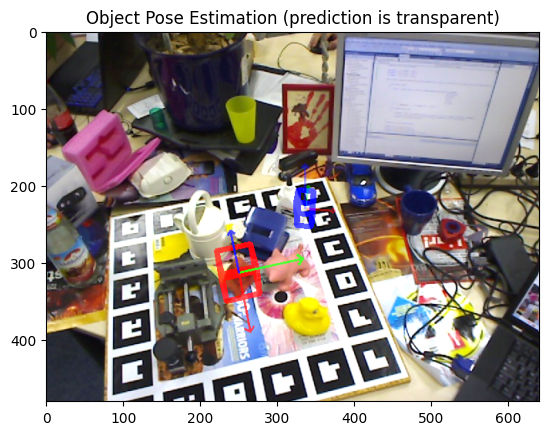

In [ ]:
config = {
    "project_name": "Baseline",
    "experiment_name": "6d_pose_estimation_baseline",
    "batch_size": 32,
    "num_epochs": 10,
    "learning_rate": 1e-4,
    "weight_decay": 1e-5,
    "backbone": "resnet18",
    "hidden_dim": 512,
    "img_size": 224,
    "alpha": 1.0,
    "beta": 1.0,
    "rotation_loss_type": "frobenius",
    "add_threshold": 0.1,
    "symmetric_objects": ["10"]
}

model = PosePredictorModel(
    backbone=config["backbone"],
    hidden_dim=config["hidden_dim"]
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# # Trainer
# trainer = PoseEstimationTrainer(model, train_loader, val_loader, device=DEVICE, config=config)
# trainer.train(num_epochs=config["num_epochs"])

# Carica checkpoint
print("Loading best model for evaluation...")
checkpoint = torch.load('./checkpoints/baseline/best_model_resnet18_lr0_0001_bs32.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=4)
test_batch = next(iter(test_loader))

for idx, batch in enumerate(test_loader):
    if idx == 0:
        images = batch['rgb'].to(device)
        gt_trans = batch['translation'].cpu().numpy()
        gt_rot = batch['rotation'].cpu().numpy()
        object_ids = batch['obj_id'].cpu().numpy()
        sample_id = batch["sample_id"]
        image_paths = batch['img_path']

        with torch.no_grad():
          pred_trans, pred_rot = model(images)
          pred_trans = pred_trans.cpu().numpy()
          pred_rot = pred_rot.cpu().numpy()

          for i in range(len(images)):
            if i == 0:
              img_path = f"./datasets/linemod/DenseFusion/Linemod_preprocessed/data/{sample_id[i].split('_')[0]}/rgb/{sample_id[i].split('_')[1]}.png"


              print(img_path, gt_trans[i], gt_rot[i], pred_trans[i], pred_rot[i])
              plotPose(img_path, gt_trans[i], gt_rot[i], pred_trans[i], pred_rot[i])

    else:
        break




In [ ]:
for idx, img in enumerate(test_batch):

    images = img['rgb'].to(device)
    gt_trans = img['translation'].cpu().numpy()
    gt_rot = img['rotation'].cpu().numpy()
    object_ids = img['obj_id'].cpu().numpy()
    sample_id = img["sample_id"]
    image_paths = img['img_path']

    with torch.no_grad():
      pred_trans, pred_rot = model(images)
      pred_trans = pred_trans.cpu().numpy()
      pred_rot = pred_rot.cpu().numpy()

      for i in range(len(images)):
        if i == 0:
          img_path = f"./datasets/linemod/DenseFusion/Linemod_preprocessed/data/{sample_id[i].split('_')[0]}/rgb/{sample_id[i].split('_')[1]}.png"


          print(img_path, gt_trans[i], gt_rot[i], pred_trans[i], pred_rot[i])
          plotPose(img_path, gt_trans[i], gt_rot[i], pred_trans[i], pred_rot[i])


TypeError: string indices must be integers, not 'str'

# Extensions

## PointeNet++

#### chat

In [ ]:
class PointNetLayer(MessagePassing): #(chat)
    """PointNet layer per estrazione feature geometriche"""
    def __init__(self, in_channels, out_channels, use_xyz=True):
        super().__init__(aggr='max')
        self.use_xyz = use_xyz
        mlp_in_channels = in_channels + 3 if use_xyz else in_channels

        self.mlp = nn.Sequential(
            nn.Linear(mlp_in_channels, out_channels),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Linear(out_channels, out_channels),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, h, pos, edge_index):
        return self.propagate(edge_index, h=h, pos=pos) # chiama automaticamente message e aggrega in base ad 'aggr'

    def message(self, h_j, pos_j, pos_i):
        geometric_feat = pos_j - pos_i
        if self.use_xyz:
            edge_feat = torch.cat([h_j, geometric_feat], dim=-1)
        else:
            edge_feat = h_j
        return self.mlp(edge_feat)


class SetAbstractionLayer(nn.Module):
    """Set Abstraction per PointNet++"""
    def __init__(self, n_points, radius, n_neighbors, in_channels, out_channels):
        super().__init__()
        self.n_points = n_points
        self.radius = radius
        self.n_neighbors = n_neighbors
        self.pointnet_layer = PointNetLayer(in_channels, out_channels)

    def forward(self, pos, h=None, batch=None):
        if batch is None:
            batch = torch.zeros(pos.size(0), dtype=torch.long, device=pos.device)
        if h is None:
            h = pos

        # Sampling
        if self.n_points is not None:
            centroids_idx = fps(pos, batch, ratio=self.n_points/pos.size(0)) #seleziona centrodi
            centroids = pos[centroids_idx]
        else:
            centroids_idx = torch.arange(pos.size(0), device=pos.device) # se non si vuole campionare prende tutti i punti
            centroids = pos

        # Grouping
        # Questo definisce il "vicinato" di ciascun centro
        edge_index = radius(pos, centroids, r=self.radius,
                           batch_x=batch, batch_y=batch[centroids_idx],
                           max_num_neighbors=self.n_neighbors)

        # PointNet
        # estrae features
        aggregated_h = self.pointnet_layer(h, pos, edge_index)

        # Aggregate per centroids
        new_h = torch.zeros(centroids.size(0), aggregated_h.size(1),
                           device=aggregated_h.device, dtype=aggregated_h.dtype)

        # prende le feature dei suoi vicini e fa max pooling tra di loro per ottenere una sola feature finale per il centro.
        for i, centroid_idx in enumerate(centroids_idx):
            mask = edge_index[1] == i
            if mask.any():
                neighbor_feats = aggregated_h[edge_index[0][mask]]
                new_h[i] = neighbor_feats.max(dim=0)[0]

        return centroids, new_h


class PointNetPlusPlus(nn.Module):
    """
    Estrattore di feature geometriche da point cloud
    Produce embeddings multi-scala per la fusion
    """
    def __init__(self, feature_dims=[64, 128, 256]):
        super().__init__()
        self.feature_dims = feature_dims

        # Multi-scale feature extraction
        self.sa1 = SetAbstractionLayer(
            n_points=512, radius=0.05, n_neighbors=32,
            in_channels=3, out_channels=feature_dims[0]
        )
        self.sa2 = SetAbstractionLayer(
            n_points=128, radius=0.1, n_neighbors=64,
            in_channels=feature_dims[0], out_channels=feature_dims[1]
        )
        self.sa3 = SetAbstractionLayer(
            n_points=32, radius=0.2, n_neighbors=64,
            in_channels=feature_dims[1], out_channels=feature_dims[2]
        )

        # Feature projection layers per diversi livelli
        self.feat_proj1 = nn.Sequential(
            nn.Linear(feature_dims[0], feature_dims[0]),
            nn.BatchNorm1d(feature_dims[0]),
            nn.ReLU()
        )
        self.feat_proj2 = nn.Sequential(
            nn.Linear(feature_dims[1], feature_dims[1]),
            nn.BatchNorm1d(feature_dims[1]),
            nn.ReLU()
        )
        self.feat_proj3 = nn.Sequential(
            nn.Linear(feature_dims[2], feature_dims[2]),
            nn.BatchNorm1d(feature_dims[2]),
            nn.ReLU()
        )

    def forward(self, pos, batch=None):
        """
        Args:
            pos: [N, 3] point cloud coordinates
            batch: [N] batch indices
        Returns:
            multi_scale_features: dict con features a diverse risoluzioni
        """
        if batch is None:
            batch = torch.zeros(pos.size(0), dtype=torch.long, device=pos.device)

        # Extract multi-scale features
        pos1, h1 = self.sa1(pos, batch=batch)      # [~512, 64]
        pos2, h2 = self.sa2(pos1, h1)             # [~128, 128]
        pos3, h3 = self.sa3(pos2, h2)             # [~32, 256]

        # Project features
        h1 = self.feat_proj1(h1)
        h2 = self.feat_proj2(h2)
        h3 = self.feat_proj3(h3)

        return {
            'level1': {'pos': pos1, 'features': h1},  # Fine details
            'level2': {'pos': pos2, 'features': h2},  # Medium details
            'level3': {'pos': pos3, 'features': h3},  # Coarse details
        }

#### claude

In [ ]:
for el in ["01","02","04","05","06","08","09","10","11","12","13","14","15"]:
  shutil.copy(f"./datasets/linemod/YOLO/datasets_cropped/{el}_gt.yml", f"./datasets/linemod/DenseFusion/Linemod_preprocessed/masked_depth/{el}_gt.yml")

In [19]:
class CustomDatasetPointCloud(Dataset):
    def __init__(self, dataset_root, split="train"):
        """
        Args:
            dataset_root (str): Path to the dataset directory.
            split (str): 'train', 'validation' or 'test'.
        """
        self.dataset_root = dataset_root
        if split == "train":
            self.split = split
        elif split == "validation":
            self.split = "val"
        else:
            self.split = "test"

        # Get list of all samples (folder_id, sample_id)
        self.samples = self.get_all_samples()

        # Check if samples were found
        if not self.samples:
            raise ValueError(f"No samples found in {self.dataset_root}. Check the dataset path and structure.")

        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])
        # Define fixed intrinsics
        self.intrinsics = (572.4114, 573.57043, 325.2611, 242.04899)

    def get_samples_id(self):
        return self.samples

    def load_image(self, img_path):
        """Load an RGB image and convert to tensor."""
        img = Image.open(img_path).convert("RGB")
        return self.transform(img)

    def get_all_samples(self):
        """Retrieve the list of all available sample indices from all folders."""
        sample_ids = []
        folder_path = os.path.join(self.dataset_root, "masked_depth", f"{self.split}")

        if os.path.exists(folder_path):
            # get name of files <folder id>_<image>
            # filter out non-npy files and extract names
            sample_ids = sorted([f.split('.')[0] for f in os.listdir(folder_path) if f.endswith('.npy')])

        return sample_ids

    def load_depth(self, path):
        return cv2.imread(path, cv2.IMREAD_UNCHANGED).astype(np.float32)

    def load_mask(self, path):
        return cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)

    def depth_to_pointcloud(self, masked_depth, intrinsics):
        """
        Convert pixel coordinates + depth to 3D metric coordinates using intrinsic parameters.
        Returns x, y, z as Nx3 array.
        """
        fx, fy, cx, cy = intrinsics
        height, width = masked_depth.shape
        valid_mask = masked_depth > 0

        u, v = np.meshgrid(np.arange(width), np.arange(height))
        u_valid = u[valid_mask]
        v_valid = v[valid_mask]
        z_valid = masked_depth[valid_mask].astype(np.float32) / 1000.0

        # Ensure z_valid is not zero or very small to avoid division by zero
        valid_depth_mask = z_valid > 1e-6
        u_valid = u_valid[valid_depth_mask]
        v_valid = v_valid[valid_depth_mask]
        z_valid = z_valid[valid_depth_mask]

        x_meters = (u_valid - cx) * z_valid / fx
        y_meters = (v_valid - cy) * z_valid / fy
        z_meters = z_valid

        pointcloud = np.stack([x_meters, y_meters, z_meters], axis=-1)  # Shape: (N, 3)
        return pointcloud

    def load_6d_pose(self, sample_id):
        """Load the 6D pose (translation and rotation) for the object in this sample."""
        # sample_id is in the format "folderId_imageId"
        label = int(sample_id.split("_")[0])
        objectId = int(sample_id.split("_")[1])

        # Load the ground truth poses from the gt.yml file
        pose_file = os.path.join(self.dataset_root, f"masked_depth/{label:02d}_gt.yml")

        # Load pose data
        with open(pose_file, 'r') as f:
            pose_data = yaml.load(f, Loader=yaml.FullLoader)

        # The key in pose_data is the image index
        image_index = objectId
        if image_index not in pose_data:
            raise KeyError(f"Sample Image ID {objectId} not found as a key in gt.yml for folder {label:02d}. Available keys: {list(pose_data.keys())}")

        # Define intrinsics
        fx, fy, cx, cy = 572.4114, 573.57043, 325.2611, 242.04899
        current_intrinsics = (fx, fy, cx, cy)

        # Load depth and mask based on the actual image file number (objectId)
        depth_path = os.path.join(self.dataset_root, f"data/{label:02d}/depth/{objectId:04d}.png")
        mask_path = os.path.join(self.dataset_root, f"data/{label:02d}/mask/{objectId:04d}.png")
        img_path = os.path.join(self.dataset_root, "data", f"{label:02d}", "rgb", f"{objectId:04d}.png")

        img = self.load_image(img_path)
        depth_img = self.load_depth(depth_path)
        mask_img = self.load_mask(mask_path)

        mask_binary = mask_img != 0
        masked_depth = np.where(mask_binary, depth_img, 0)

        # Use the intrinsics for this specific image
        pointcloud = self.depth_to_pointcloud(masked_depth, current_intrinsics)

        # Iterate through the list of poses for this image index
        found_pose = False
        for pose_entry in pose_data[image_index]:
            # Find the pose corresponding to the correct object ID (label)
            if int(pose_entry['obj_id']) == int(label):
                translation = np.array(pose_entry['cam_t_m2c'], dtype=np.float32)
                rotation = np.array(pose_entry['cam_R_m2c'], dtype=np.float32).reshape(3, 3)
                quaternion = np.array(pose_entry["quaternion"], dtype=np.float32)

                # bbox processing
                x_min, y_min, width, height = np.array(pose_entry['obj_bb'], dtype=np.float32)
                x_center = x_min + width/2
                y_center = y_min + height/2

                # Normalize bbox coordinates
                bbox = np.array([x_center/IMG_WIDTH, y_center/IMG_HEIGHT, width/IMG_WIDTH, height/IMG_HEIGHT], dtype=np.float32)
                obj_id = np.array(pose_entry['obj_id'], dtype=np.float32)
                found_pose = True
                break

        if not found_pose:
            raise ValueError(f"Pose for object ID {label} not found in image index {image_index} of gt.yml.")

        return img, pointcloud, translation, rotation, bbox, obj_id, quaternion

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        img, pointcloud, translation, rotation, bbox, obj_id, quaternion = self.load_6d_pose(sample)

        return {
            "rgb": img,
            "pointcloud": torch.tensor(pointcloud, dtype=torch.float32),
            "translation": torch.tensor(translation, dtype=torch.float32),
            "rotation": torch.tensor(rotation, dtype=torch.float32),
            "bbox": torch.tensor(bbox, dtype=torch.float32),
            "obj_id": torch.tensor(obj_id, dtype=torch.float32),
            "quaternion": torch.tensor(quaternion, dtype=torch.float32),
            "sample_id": sample
        }


def pointcloud_collate_fn(batch):
    """
    Custom collate function for batching variable-sized point clouds.
    """
    pointclouds = [item['pointcloud'] for item in batch]
    other_data_list = [{k: v for k, v in item.items() if k != 'pointcloud'} for item in batch]

    batched_pointcloud = torch.cat(pointclouds, dim=0)
    batch_tensor = torch.cat([
        torch.full((p.size(0),), i, dtype=torch.long) for i, p in enumerate(pointclouds)
    ], dim=0)

    collated_other_data = torch.utils.data.dataloader.default_collate(other_data_list)

    # Use consistent key naming - 'point_cloud' (with underscore)
    final_batch = {
        'point_cloud': batched_pointcloud,  # Changed from 'pointcloud' to 'point_cloud'
        'batch': batch_tensor
    }
    final_batch.update(collated_other_data)

    return final_batch

In [20]:
dataset_root = "./datasets/linemod/DenseFusion/Linemod_preprocessed/"

train_dataset = CustomDatasetPointCloud(dataset_root, split='train')
print(f'Training samples: {len(train_dataset)}')

val_dataset = CustomDatasetPointCloud(dataset_root, split='validation')
print(f'Validation samples: {len(val_dataset)}')

test_dataset = CustomDatasetPointCloud(dataset_root, split='test')
print(f'Testing samples: {len(test_dataset)}')

Training samples: 11060
Validation samples: 2370
Testing samples: 2370


### classes

In [ ]:
class PointNetLayer(MessagePassing):
    """PointNet layer per estrazione feature geometriche"""
    def __init__(self, in_channels, out_channels, use_xyz=True):
        super().__init__(aggr='max')
        self.use_xyz = use_xyz
        mlp_in_channels = in_channels + 3 if use_xyz else in_channels

        self.mlp = nn.Sequential(
            nn.Linear(mlp_in_channels, out_channels),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Linear(out_channels, out_channels),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, h, pos, edge_index):
        return self.propagate(edge_index, h=h, pos=pos)

    def message(self, h_j, pos_j, pos_i):
        geometric_feat = pos_j - pos_i
        if self.use_xyz:
            edge_feat = torch.cat([h_j, geometric_feat], dim=-1)
        else:
            edge_feat = h_j
        return self.mlp(edge_feat)


class SetAbstractionLayer(nn.Module):
    """Set Abstraction per PointNet++"""
    def __init__(self, n_points, radius, n_neighbors, in_channels, out_channels):
        super().__init__()
        self.n_points = n_points
        self.radius = radius
        self.n_neighbors = n_neighbors
        self.pointnet_layer = PointNetLayer(in_channels, out_channels)

    def forward(self, pos, h=None, batch=None):
        if batch is None:
            batch = torch.zeros(pos.size(0), dtype=torch.long, device=pos.device)
        if h is None:
            h = pos

        # Sampling with proper batch handling
        if self.n_points is not None:
            centroids_idx = fps(pos, batch, ratio=self.n_points/pos.size(0))
            centroids = pos[centroids_idx]
            # Update batch indices for centroids
            centroids_batch = batch[centroids_idx]
        else:
            centroids_idx = torch.arange(pos.size(0), device=pos.device)
            centroids = pos
            centroids_batch = batch

        # Grouping
        edge_index = radius(pos, centroids, r=self.radius,
                           batch_x=batch, batch_y=centroids_batch,
                           max_num_neighbors=self.n_neighbors)

        # PointNet
        aggregated_h = self.pointnet_layer(h, pos, edge_index)

        # Aggregate per centroids
        new_h = torch.zeros(centroids.size(0), aggregated_h.size(1),
                           device=aggregated_h.device, dtype=aggregated_h.dtype)

        for i, centroid_idx in enumerate(centroids_idx):
            mask = edge_index[1] == i
            if mask.any():
                neighbor_feats = aggregated_h[edge_index[0][mask]]
                new_h[i] = neighbor_feats.max(dim=0)[0]

        return centroids, new_h, centroids_batch


class GeometricFeatureExtractor(nn.Module):
    """
    Estrattore di feature geometriche da point cloud
    Produce embeddings multi-scala per la fusion
    """
    def __init__(self, feature_dims=[64, 128, 256]):
        super().__init__()
        self.feature_dims = feature_dims

        # Multi-scale feature extraction
        self.sa1 = SetAbstractionLayer(
            n_points=512, radius=0.05, n_neighbors=32,
            in_channels=3, out_channels=feature_dims[0]
        )
        self.sa2 = SetAbstractionLayer(
            n_points=128, radius=0.1, n_neighbors=64,
            in_channels=feature_dims[0], out_channels=feature_dims[1]
        )
        self.sa3 = SetAbstractionLayer(
            n_points=32, radius=0.2, n_neighbors=64,
            in_channels=feature_dims[1], out_channels=feature_dims[2]
        )

        # Feature projection layers per diversi livelli
        self.feat_proj1 = nn.Sequential(
            nn.Linear(feature_dims[0], feature_dims[0]),
            nn.BatchNorm1d(feature_dims[0]),
            nn.ReLU()
        )
        self.feat_proj2 = nn.Sequential(
            nn.Linear(feature_dims[1], feature_dims[1]),
            nn.BatchNorm1d(feature_dims[1]),
            nn.ReLU()
        )
        self.feat_proj3 = nn.Sequential(
            nn.Linear(feature_dims[2], feature_dims[2]),
            nn.BatchNorm1d(feature_dims[2]),
            nn.ReLU()
        )

    def forward(self, pos, batch=None):
        """
        Args:
            pos: [N, 3] point cloud coordinates
            batch: [N] batch indices
        Returns:
            multi_scale_features: dict con features a diverse risoluzioni
        """
        if batch is None:
            batch = torch.zeros(pos.size(0), dtype=torch.long, device=pos.device)

        # Extract multi-scale features with proper batch tracking
        pos1, h1, batch1 = self.sa1(pos, batch=batch)      # [~512, 64]
        pos2, h2, batch2 = self.sa2(pos1, h1, batch1)      # [~128, 128]
        pos3, h3, batch3 = self.sa3(pos2, h2, batch2)      # [~32, 256]

        # Project features
        h1 = self.feat_proj1(h1)
        h2 = self.feat_proj2(h2)
        h3 = self.feat_proj3(h3)

        return {
            'level1': {'pos': pos1, 'features': h1, 'batch': batch1},  # Fine details
            'level2': {'pos': pos2, 'features': h2, 'batch': batch2},  # Medium details
            'level3': {'pos': pos3, 'features': h3, 'batch': batch3},  # Coarse details
        }


class PointProjector(nn.Module):
    """
    Proietta i punti 3D nello spazio immagine usando parametri intrinseci fissi
    Assume che i punti siano già nel sistema di coordinate della camera
    """
    def __init__(self, fx=572.4114, fy=573.57043, cx=325.2611, cy=242.04899, img_width=640, img_height=480):
        super().__init__()
        # Fixed camera intrinsics matrix
        self.register_buffer('camera_intrinsics', torch.tensor([
            [fx, 0.0, cx],
            [0.0, fy, cy],
            [0.0, 0.0, 1.0]
        ]))
        self.img_width = img_width
        self.img_height = img_height

    def forward(self, points_3d):
        """
        Args:
            points_3d: [N, 3] coordinate 3D dei punti nel sistema camera
        Returns:
            pixel_coords: [N, 2] coordinate pixel (u, v)
            valid_mask: [N] mask per punti validi (dentro l'immagine)
        """
        # Project to image plane (assuming points are already in camera coordinates)
        points_2d_homo = torch.matmul(self.camera_intrinsics, points_3d.T).T
        pixel_coords = points_2d_homo[:, :2] / (points_2d_homo[:, 2:3] + 1e-8)

        # Valid mask (points in front of camera and within image bounds)
        valid_depth = points_3d[:, 2] > 0.1  # min depth
        valid_u = (pixel_coords[:, 0] >= 0) & (pixel_coords[:, 0] < self.img_width)
        valid_v = (pixel_coords[:, 1] >= 0) & (pixel_coords[:, 1] < self.img_height)
        valid_mask = valid_depth & valid_u & valid_v

        return pixel_coords, valid_mask


class PixelWiseFusionNetwork(nn.Module):
    """
    Network principale per fusion pixel-wise di features geometriche e visive
    """
    def __init__(self,
                 geometric_dims=[64, 128, 256],
                 image_backbone='resnet50',
                 fusion_dim=128,
                 output_classes=None,
                 fx=572.4114, fy=573.57043, cx=325.2611, cy=242.04899,
                 img_width=640, img_height=480):
        super().__init__()

        self.geometric_dims = geometric_dims
        self.fusion_dim = fusion_dim
        self.output_classes = output_classes

        # Geometric feature extractor
        self.geometric_extractor = GeometricFeatureExtractor(geometric_dims)

        # Point projector with fixed intrinsics
        self.point_projector = PointProjector(fx, fy, cx, cy, img_width, img_height)

        # Image feature extractor (CNN backbone)
        if image_backbone == 'resnet50':
            self.backbone = models.resnet50(weights="ResNet50_Weights.IMAGENET1K_V2")
            self.image_encoder = nn.Sequential(*list(self.backbone.children())[:-2])
            image_feat_dim = 2048
        else:
            raise NotImplementedError(f"Backbone {image_backbone} not implemented")

        for param in self.backbone.parameters():
            param.requires_grad = False

        # Feature fusion layers per ogni livello
        self.fusion_layers = nn.ModuleDict({
            'level1': self._make_fusion_layer(geometric_dims[0] + image_feat_dim, fusion_dim),
            'level2': self._make_fusion_layer(geometric_dims[1] + image_feat_dim, fusion_dim),
            'level3': self._make_fusion_layer(geometric_dims[2] + image_feat_dim, fusion_dim)
        })

        # Multi-level feature aggregation
        self.feature_aggregator = nn.Sequential(
            nn.Conv2d(fusion_dim * 3, fusion_dim, 1),
            nn.BatchNorm2d(fusion_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(fusion_dim, fusion_dim, 3, padding=1),
            nn.BatchNorm2d(fusion_dim),
            nn.ReLU(inplace=True)
        )

        # Output head (optional)
        if output_classes is not None:
            self.output_head = nn.Conv2d(fusion_dim, output_classes, 1)

    def _make_fusion_layer(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.BatchNorm1d(out_dim),
            nn.ReLU(inplace=True),
            nn.Linear(out_dim, out_dim),
            nn.BatchNorm1d(out_dim),
            nn.ReLU(inplace=True)
        )

    def forward(self,
                point_cloud,
                image,
                batch=None):
        """
        Args:
            point_cloud: [N, 3] coordinate 3D (già nel sistema camera)
            image: [B, 3, H, W] immagini RGB
            batch: [N] batch assignment per point cloud
        Returns:
            fused_features: [B, fusion_dim, H, W] feature fuse pixel-wise
        """
        B, _, H, W = image.shape

        # Extract geometric features
        geometric_features = self.geometric_extractor(point_cloud, batch)

        # Extract image features
        image_features = self.image_encoder(image)  # [B, 2048, H/32, W/32]
        image_features = F.interpolate(image_features, size=(H, W), mode='bilinear', align_corners=False)

        # Initialize fusion feature maps
        fusion_maps = []

        for level_idx, level_name in enumerate(['level1', 'level2', 'level3']):
            level_data = geometric_features[level_name]
            points_3d = level_data['pos']
            geom_feats = level_data['features']
            points_batch = level_data['batch']  # Use proper batch indices

            # Initialize pixel-wise geometric features
            pixel_geom_features = torch.zeros(B, self.geometric_dims[level_idx], H, W,
                                            device=image.device)

            # Process each batch
            for b in range(B):
                # Use the proper batch indices for this level
                batch_mask = points_batch == b
                if batch_mask.sum() == 0:
                    continue

                batch_points = points_3d[batch_mask]
                batch_geom_feats = geom_feats[batch_mask]

                # Project points to image using fixed intrinsics
                pixel_coords, valid_mask = self.point_projector(batch_points)

                # Map geometric features to pixels
                valid_points = batch_points[valid_mask]
                valid_geom_feats = batch_geom_feats[valid_mask]
                valid_pixels = pixel_coords[valid_mask]

                if len(valid_points) > 0:
                    # Discretize pixel coordinates
                    u_coords = torch.clamp(valid_pixels[:, 0].long(), 0, W-1)
                    v_coords = torch.clamp(valid_pixels[:, 1].long(), 0, H-1)

                    # Aggregate features per pixel (average pooling for overlapping points)
                    for i, (u, v) in enumerate(zip(u_coords, v_coords)):
                        pixel_geom_features[b, :, v, u] = valid_geom_feats[i]

            # Flatten for fusion
            pixel_geom_flat = pixel_geom_features.permute(0, 2, 3, 1).reshape(-1, self.geometric_dims[level_idx])
            image_feat_flat = image_features.permute(0, 2, 3, 1).reshape(-1, image_features.size(1))

            # Concatenate and fuse
            combined_feats = torch.cat([pixel_geom_flat, image_feat_flat], dim=1)
            fused_feats = self.fusion_layers[level_name](combined_feats)

            # Reshape back to spatial
            fused_map = fused_feats.reshape(B, H, W, self.fusion_dim).permute(0, 3, 1, 2)
            fusion_maps.append(fused_map)

        # Aggregate multi-level features
        multi_level_features = torch.cat(fusion_maps, dim=1)  # [B, fusion_dim*3, H, W]
        final_features = self.feature_aggregator(multi_level_features)

        if self.output_classes is not None:
            output = self.output_head(final_features)
            return final_features, output

        return final_features


class PoseEstimationPipeline(nn.Module):
    """
    Pipeline per stima di posa con output:
    - Matrice di rotazione 3x3
    - Vettore di traslazione 3D
    """
    def __init__(self,
                 geometric_dims=[64, 128, 256],
                 fusion_dim=128,
                 fx=572.4114, fy=573.57043, cx=325.2611, cy=242.04899,
                 img_width=640, img_height=480):
        super().__init__()

        # Fusion network (senza output_classes)
        self.fusion_network = PixelWiseFusionNetwork(
            geometric_dims=geometric_dims,
            fusion_dim=fusion_dim,
            output_classes=None,  # Non serve per pose estimation
            fx=fx, fy=fy, cx=cx, cy=cy,
            img_width=img_width, img_height=img_height
        )

        # Global pooling per ridurre le feature spaziali
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Feature encoder condiviso
        self.shared_encoder = nn.Sequential(
            nn.Linear(fusion_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Head separati per rotazione e traslazione
        self.rotation_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 9)   # 9 elementi per matrice 3x3
        )

        self.translation_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 3)   # traslazione 3D
        )

    def forward(self, batch_data):
        """
        Args:
            batch_data: dict contenente point_cloud, image, batch
        Returns:
            rotation_matrix: [B, 3, 3] matrice di rotazione
            translation: [B, 3] vettore di traslazione
        """
        # Estrai feature fuse
        fused_features = self.fusion_network(
            point_cloud=batch_data['pointcloud'],  # Changed from 'pointcloud'
            image=batch_data['rgb'],
            batch=batch_data.get('batch', None)
        )

        # Global pooling: [B, fusion_dim, H, W] -> [B, fusion_dim]
        global_features = self.global_pool(fused_features)
        global_features = global_features.flatten(1)

        # Feature encoding condiviso
        encoded_features = self.shared_encoder(global_features)

        # Predici rotazione (9 elementi)
        rotation_9d = self.rotation_head(encoded_features)  # [B, 9]

        # Predici traslazione
        translation = self.translation_head(encoded_features)  # [B, 3]

        # Reshaping in matrice 3x3
        rotation_matrix = rotation_9d.view(-1, 3, 3)  # [B, 3, 3]

        # Normalizza per garantire ortonormalità (opzionale)
        rotation_matrix = self.orthogonalize_rotation(rotation_matrix)

        return rotation_matrix, translation

    def orthogonalize_rotation(self, rotation_matrix):
        """
        Ortogonalizza la matrice di rotazione usando SVD
        Garantisce che sia una rotazione valida

        Args:
            rotation_matrix: [B, 3, 3]
        Returns:
            orthogonal_matrix: [B, 3, 3] - matrice di rotazione ortonormale
        """
        batch_size = rotation_matrix.shape[0]
        orthogonal_matrices = []

        for i in range(batch_size):
            R = rotation_matrix[i]

            # SVD decomposition
            U, S, V = torch.svd(R)

            # Costruisci matrice ortogonale
            R_ortho = torch.mm(U, V.t())

            # Assicurati che det(R) = 1 (non -1)
            if torch.det(R_ortho) < 0:
                V[-1, :] *= -1
                R_ortho = torch.mm(U, V.t())

            orthogonal_matrices.append(R_ortho)

        return torch.stack(orthogonal_matrices, dim=0)


# Esempio di utilizzo completo
if __name__ == "__main__":
    # Crea il modello per pose estimation
    model = PoseEstimationPipeline(
        geometric_dims=[64, 128, 256],
        fusion_dim=128,
        fx=572.4114, fy=573.57043, cx=325.2611, cy=242.04899,
        img_width=640, img_height=480
    )

    # Dati di esempio
    batch_size = 2
    n_points = 1024
    H, W = 480, 640

    point_cloud = torch.randn(batch_size * n_points, 3)
    point_cloud[:, 2] = torch.abs(point_cloud[:, 2]) + 1.0

    image = torch.randn(batch_size, 3, H, W)
    batch = torch.repeat_interleave(torch.arange(batch_size), n_points)

    batch_data = {
        'pointcloud': point_cloud,
        'rgb': image,
        'batch': batch
    }

    # Forward pass
    with torch.no_grad():
        rotation_matrix, translation = model(batch_data)

        print(f"Rotation matrix shape: {rotation_matrix.shape}")  # [2, 3, 3]
        print(f"Translation vector shape: {translation.shape}")   # [2, 3]

        print(f"\nBatch 0:")
        print(f"Rotation matrix:\n{rotation_matrix[0]}")
        print(f"Translation: {translation[0]}")

        # Verifica che la matrice di rotazione sia ortonormale
        R = rotation_matrix[0]
        should_be_identity = torch.mm(R, R.t())
        det = torch.det(R)
        print(f"\nVerifica ortonormalità:")
        print(f"R @ R.T (dovrebbe essere identità):\n{should_be_identity}")
        print(f"det(R) (dovrebbe essere 1): {det:.4f}")

        print("\n✅ 6DoF Pose estimation completed!")
        print("📝 Output: matrice rotazione 3x3 + vettore traslazione 3D")
        print("📝 Matrice 3x3 predetta direttamente e ortogonalizzata con SVD")


Rotation matrix shape: torch.Size([2, 3, 3])
Translation vector shape: torch.Size([2, 3])

Batch 0:
Rotation matrix:
tensor([[-0.9018, -0.1060,  0.4188],
        [ 0.4300, -0.1269,  0.8938],
        [-0.0416,  0.9862,  0.1600]])
Translation: tensor([-0.0629, -0.0325, -0.0535])

Verifica ortonormalità:
R @ R.T (dovrebbe essere identità):
tensor([[ 1.0000e+00,  4.1258e-07, -1.4901e-08],
        [ 4.1258e-07,  1.0000e+00,  5.9605e-08],
        [-1.4901e-08,  5.9605e-08,  1.0000e+00]])
det(R) (dovrebbe essere 1): 1.0000

✅ 6DoF Pose estimation completed!
📝 Output: matrice rotazione 3x3 + vettore traslazione 3D
📝 Matrice 3x3 predetta direttamente e ortogonalizzata con SVD


### Training

In [21]:
class PointNetLayer(MessagePassing):
    """PointNet layer per estrazione feature geometriche"""
    def __init__(self, in_channels, out_channels, use_xyz=True):
        super().__init__(aggr='max')
        self.use_xyz = use_xyz
        mlp_in_channels = in_channels + 3 if use_xyz else in_channels

        self.mlp = nn.Sequential(
            nn.Linear(mlp_in_channels, out_channels),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Linear(out_channels, out_channels),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, h, pos, edge_index):
        return self.propagate(edge_index, h=h, pos=pos)

    def message(self, h_j, pos_j, pos_i):
        geometric_feat = pos_j - pos_i
        if self.use_xyz:
            edge_feat = torch.cat([h_j, geometric_feat], dim=-1)
        else:
            edge_feat = h_j
        return self.mlp(edge_feat)


class SetAbstractionLayer(nn.Module):
    """Set Abstraction per PointNet++"""
    def __init__(self, n_points, radius, n_neighbors, in_channels, out_channels):
        super().__init__()
        self.n_points = n_points
        self.radius = radius
        self.n_neighbors = n_neighbors
        self.pointnet_layer = PointNetLayer(in_channels, out_channels)

    def forward(self, pos, h=None, batch=None):
        if batch is None:
            batch = torch.zeros(pos.size(0), dtype=torch.long, device=pos.device)
        if h is None:
            h = pos

        # Sampling with proper batch handling
        if self.n_points is not None:
            centroids_idx = fps(pos, batch, ratio=self.n_points/pos.size(0))
            centroids = pos[centroids_idx]
            # Update batch indices for centroids
            centroids_batch = batch[centroids_idx]
        else:
            centroids_idx = torch.arange(pos.size(0), device=pos.device)
            centroids = pos
            centroids_batch = batch

        # Grouping
        edge_index = radius(pos, centroids, r=self.radius,
                           batch_x=batch, batch_y=centroids_batch,
                           max_num_neighbors=self.n_neighbors)

        # PointNet
        aggregated_h = self.pointnet_layer(h, pos, edge_index)

        # Aggregate per centroids
        new_h = torch.zeros(centroids.size(0), aggregated_h.size(1),
                           device=aggregated_h.device, dtype=aggregated_h.dtype)

        for i, centroid_idx in enumerate(centroids_idx):
            mask = edge_index[1] == i
            if mask.any():
                neighbor_feats = aggregated_h[edge_index[0][mask]]
                new_h[i] = neighbor_feats.max(dim=0)[0]

        return centroids, new_h, centroids_batch


class GeometricFeatureExtractor(nn.Module):
    """
    Estrattore di feature geometriche da point cloud
    Produce embeddings multi-scala per la fusion
    """
    def __init__(self, feature_dims=[64, 128, 256]):
        super().__init__()
        self.feature_dims = feature_dims

        # Multi-scale feature extraction
        self.sa1 = SetAbstractionLayer(
            n_points=512, radius=0.05, n_neighbors=32,
            in_channels=3, out_channels=feature_dims[0]
        )
        self.sa2 = SetAbstractionLayer(
            n_points=128, radius=0.1, n_neighbors=64,
            in_channels=feature_dims[0], out_channels=feature_dims[1]
        )
        self.sa3 = SetAbstractionLayer(
            n_points=32, radius=0.2, n_neighbors=64,
            in_channels=feature_dims[1], out_channels=feature_dims[2]
        )

        # Feature projection layers per diversi livelli
        self.feat_proj1 = nn.Sequential(
            nn.Linear(feature_dims[0], feature_dims[0]),
            nn.BatchNorm1d(feature_dims[0]),
            nn.ReLU()
        )
        self.feat_proj2 = nn.Sequential(
            nn.Linear(feature_dims[1], feature_dims[1]),
            nn.BatchNorm1d(feature_dims[1]),
            nn.ReLU()
        )
        self.feat_proj3 = nn.Sequential(
            nn.Linear(feature_dims[2], feature_dims[2]),
            nn.BatchNorm1d(feature_dims[2]),
            nn.ReLU()
        )

    def forward(self, pos, batch=None):
        """
        Args:
            pos: [N, 3] point cloud coordinates
            batch: [N] batch indices
        Returns:
            multi_scale_features: dict con features a diverse risoluzioni
        """
        if batch is None:
            batch = torch.zeros(pos.size(0), dtype=torch.long, device=pos.device)

        # Extract multi-scale features with proper batch tracking
        pos1, h1, batch1 = self.sa1(pos, batch=batch)      # [~512, 64]
        pos2, h2, batch2 = self.sa2(pos1, h1, batch1)      # [~128, 128]
        pos3, h3, batch3 = self.sa3(pos2, h2, batch2)      # [~32, 256]

        # Project features
        h1 = self.feat_proj1(h1)
        h2 = self.feat_proj2(h2)
        h3 = self.feat_proj3(h3)

        return {
            'level1': {'pos': pos1, 'features': h1, 'batch': batch1},  # Fine details
            'level2': {'pos': pos2, 'features': h2, 'batch': batch2},  # Medium details
            'level3': {'pos': pos3, 'features': h3, 'batch': batch3},  # Coarse details
        }


class PointProjector(nn.Module):
    """
    Proietta i punti 3D nello spazio immagine usando parametri intrinseci fissi
    Assume che i punti siano già nel sistema di coordinate della camera
    """
    def __init__(self, fx=572.4114, fy=573.57043, cx=325.2611, cy=242.04899, img_width=640, img_height=480):
        super().__init__()
        # Fixed camera intrinsics matrix
        self.register_buffer('camera_intrinsics', torch.tensor([
            [fx, 0.0, cx],
            [0.0, fy, cy],
            [0.0, 0.0, 1.0]
        ]))
        self.img_width = img_width
        self.img_height = img_height

    def forward(self, points_3d):
        """
        Args:
            points_3d: [N, 3] coordinate 3D dei punti nel sistema camera
        Returns:
            pixel_coords: [N, 2] coordinate pixel (u, v)
            valid_mask: [N] mask per punti validi (dentro l'immagine)
        """
        # Project to image plane (assuming points are already in camera coordinates)
        points_2d_homo = torch.matmul(self.camera_intrinsics, points_3d.T).T
        pixel_coords = points_2d_homo[:, :2] / (points_2d_homo[:, 2:3] + 1e-8)

        # Valid mask (points in front of camera and within image bounds)
        valid_depth = points_3d[:, 2] > 0.1  # min depth
        valid_u = (pixel_coords[:, 0] >= 0) & (pixel_coords[:, 0] < self.img_width)
        valid_v = (pixel_coords[:, 1] >= 0) & (pixel_coords[:, 1] < self.img_height)
        valid_mask = valid_depth & valid_u & valid_v

        return pixel_coords, valid_mask


class PixelWiseFusionNetwork(nn.Module):
    """
    Network principale per fusion pixel-wise di features geometriche e visive
    """
    def __init__(self,
                 geometric_dims=[64, 128, 256],
                 image_backbone='resnet50',
                 fusion_dim=128,
                 output_classes=None,
                 fx=572.4114, fy=573.57043, cx=325.2611, cy=242.04899,
                 img_width=640, img_height=480):
        super().__init__()

        self.geometric_dims = geometric_dims
        self.fusion_dim = fusion_dim
        self.output_classes = output_classes

        # Geometric feature extractor
        self.geometric_extractor = GeometricFeatureExtractor(geometric_dims)

        # Point projector with fixed intrinsics
        self.point_projector = PointProjector(fx, fy, cx, cy, img_width, img_height)

        # Image feature extractor (CNN backbone)
        if image_backbone == 'resnet50':
            self.backbone = models.resnet50(weights="ResNet50_Weights.IMAGENET1K_V2")
            self.image_encoder = nn.Sequential(*list(self.backbone.children())[:-2])
            image_feat_dim = 2048
        else:
            raise NotImplementedError(f"Backbone {image_backbone} not implemented")

        for param in self.backbone.parameters():
            param.requires_grad = False

        # Feature fusion layers per ogni livello
        self.fusion_layers = nn.ModuleDict({
            'level1': self._make_fusion_layer(geometric_dims[0] + image_feat_dim, fusion_dim),
            'level2': self._make_fusion_layer(geometric_dims[1] + image_feat_dim, fusion_dim),
            'level3': self._make_fusion_layer(geometric_dims[2] + image_feat_dim, fusion_dim)
        })

        # Multi-level feature aggregation
        self.feature_aggregator = nn.Sequential(
            nn.Conv2d(fusion_dim * 3, fusion_dim, 1),
            nn.BatchNorm2d(fusion_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(fusion_dim, fusion_dim, 3, padding=1),
            nn.BatchNorm2d(fusion_dim),
            nn.ReLU(inplace=True)
        )

        # Output head (optional)
        if output_classes is not None:
            self.output_head = nn.Conv2d(fusion_dim, output_classes, 1)

    def _make_fusion_layer(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.BatchNorm1d(out_dim),
            nn.ReLU(inplace=True),
            nn.Linear(out_dim, out_dim),
            nn.BatchNorm1d(out_dim),
            nn.ReLU(inplace=True)
        )

    def forward(self,
                point_cloud,
                image,
                batch=None):
        """
        Args:
            point_cloud: [N, 3] coordinate 3D (già nel sistema camera)
            image: [B, 3, H, W] immagini RGB
            batch: [N] batch assignment per point cloud
        Returns:
            fused_features: [B, fusion_dim, H, W] feature fuse pixel-wise
        """
        B, _, H, W = image.shape

        # Extract geometric features
        geometric_features = self.geometric_extractor(point_cloud, batch)

        # Extract image features
        image_features = self.image_encoder(image)  # [B, 2048, H/32, W/32]
        image_features = F.interpolate(image_features, size=(H, W), mode='bilinear', align_corners=False)

        # Initialize fusion feature maps
        fusion_maps = []

        for level_idx, level_name in enumerate(['level1', 'level2', 'level3']):
            level_data = geometric_features[level_name]
            points_3d = level_data['pos']
            geom_feats = level_data['features']
            points_batch = level_data['batch']  # Use proper batch indices

            # Initialize pixel-wise geometric features
            pixel_geom_features = torch.zeros(B, self.geometric_dims[level_idx], H, W,
                                            device=image.device)

            # Process each batch
            for b in range(B):
                # Use the proper batch indices for this level
                batch_mask = points_batch == b
                if batch_mask.sum() == 0:
                    continue

                batch_points = points_3d[batch_mask]
                batch_geom_feats = geom_feats[batch_mask]

                # Project points to image using fixed intrinsics
                pixel_coords, valid_mask = self.point_projector(batch_points)

                # Map geometric features to pixels
                valid_points = batch_points[valid_mask]
                valid_geom_feats = batch_geom_feats[valid_mask]
                valid_pixels = pixel_coords[valid_mask]

                if len(valid_points) > 0:
                    # Discretize pixel coordinates
                    u_coords = torch.clamp(valid_pixels[:, 0].long(), 0, W-1)
                    v_coords = torch.clamp(valid_pixels[:, 1].long(), 0, H-1)

                    # Aggregate features per pixel (average pooling for overlapping points)
                    for i, (u, v) in enumerate(zip(u_coords, v_coords)):
                        pixel_geom_features[b, :, v, u] = valid_geom_feats[i]

            # Flatten for fusion
            pixel_geom_flat = pixel_geom_features.permute(0, 2, 3, 1).reshape(-1, self.geometric_dims[level_idx])
            image_feat_flat = image_features.permute(0, 2, 3, 1).reshape(-1, image_features.size(1))

            # Concatenate and fuse
            combined_feats = torch.cat([pixel_geom_flat, image_feat_flat], dim=1)
            fused_feats = self.fusion_layers[level_name](combined_feats)

            # Reshape back to spatial
            fused_map = fused_feats.reshape(B, H, W, self.fusion_dim).permute(0, 3, 1, 2)
            fusion_maps.append(fused_map)

        # Aggregate multi-level features
        multi_level_features = torch.cat(fusion_maps, dim=1)  # [B, fusion_dim*3, H, W]
        final_features = self.feature_aggregator(multi_level_features)

        if self.output_classes is not None:
            output = self.output_head(final_features)
            return final_features, output

        return final_features


class PoseEstimationPipeline(nn.Module):
    """
    Pipeline per stima di posa con output:
    - Matrice di rotazione 3x3
    - Vettore di traslazione 3D
    """
    def __init__(self,
                 geometric_dims=[64, 128, 256],
                 fusion_dim=128,
                 fx=572.4114, fy=573.57043, cx=325.2611, cy=242.04899,
                 img_width=640, img_height=480):
        super().__init__()

        # Fusion network (senza output_classes)
        self.fusion_network = PixelWiseFusionNetwork(
            geometric_dims=geometric_dims,
            fusion_dim=fusion_dim,
            output_classes=None,  # Non serve per pose estimation
            fx=fx, fy=fy, cx=cx, cy=cy,
            img_width=img_width, img_height=img_height
        )

        # Global pooling per ridurre le feature spaziali
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Feature encoder condiviso
        self.shared_encoder = nn.Sequential(
            nn.Linear(fusion_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Head separati per rotazione e traslazione
        self.rotation_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 9)   # 9 elementi per matrice 3x3
        )

        self.translation_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 3)   # traslazione 3D
        )

    def forward(self, batch_data):
        """
        Args:
            batch_data: dict contenente point_cloud, image, batch
        Returns:
            rotation_matrix: [B, 3, 3] matrice di rotazione
            translation: [B, 3] vettore di traslazione
        """
        # Estrai feature fuse
        fused_features = self.fusion_network(
            point_cloud=batch_data['pointcloud'],  # Changed from 'pointcloud'
            image=batch_data['rgb'],
            batch=batch_data.get('batch', None)
        )

        # Global pooling: [B, fusion_dim, H, W] -> [B, fusion_dim]
        global_features = self.global_pool(fused_features)
        global_features = global_features.flatten(1)

        # Feature encoding condiviso
        encoded_features = self.shared_encoder(global_features)

        # Predici rotazione (9 elementi)
        rotation_9d = self.rotation_head(encoded_features)  # [B, 9]

        # Predici traslazione
        translation = self.translation_head(encoded_features)  # [B, 3]

        # Reshaping in matrice 3x3
        rotation_matrix = rotation_9d.view(-1, 3, 3)  # [B, 3, 3]

        # Normalizza per garantire ortonormalità (opzionale)
        rotation_matrix = self.orthogonalize_rotation(rotation_matrix)

        return rotation_matrix, translation

    def orthogonalize_rotation(self, rotation_matrix):
        """
        Ortogonalizza la matrice di rotazione usando SVD
        Garantisce che sia una rotazione valida

        Args:
            rotation_matrix: [B, 3, 3]
        Returns:
            orthogonal_matrix: [B, 3, 3] - matrice di rotazione ortonormale
        """
        batch_size = rotation_matrix.shape[0]
        orthogonal_matrices = []

        for i in range(batch_size):
            R = rotation_matrix[i]

            # SVD decomposition
            U, S, V = torch.svd(R)

            # Costruisci matrice ortogonale
            R_ortho = torch.mm(U, V.t())

            # Assicurati che det(R) = 1 (non -1)
            if torch.det(R_ortho) < 0:
                V[-1, :] *= -1
                R_ortho = torch.mm(U, V.t())

            orthogonal_matrices.append(R_ortho)

        return torch.stack(orthogonal_matrices, dim=0)


# Esempio di utilizzo completo
if __name__ == "__main__":
    # Crea il modello per pose estimation
    model = PoseEstimationPipeline(
        geometric_dims=[64, 128, 256],
        fusion_dim=128,
        fx=572.4114, fy=573.57043, cx=325.2611, cy=242.04899,
        img_width=640, img_height=480
    )

    # Dati di esempio
    batch_size = 2
    n_points = 1024
    H, W = 480, 640

    point_cloud = torch.randn(batch_size * n_points, 3)
    point_cloud[:, 2] = torch.abs(point_cloud[:, 2]) + 1.0

    image = torch.randn(batch_size, 3, H, W)
    batch = torch.repeat_interleave(torch.arange(batch_size), n_points)

    batch_data = {
        'pointcloud': point_cloud,
        'rgb': image,
        'batch': batch
    }

    # Forward pass
    with torch.no_grad():
        rotation_matrix, translation = model(batch_data)

        print(f"Rotation matrix shape: {rotation_matrix.shape}")  # [2, 3, 3]
        print(f"Translation vector shape: {translation.shape}")   # [2, 3]

        print(f"\nBatch 0:")
        print(f"Rotation matrix:\n{rotation_matrix[0]}")
        print(f"Translation: {translation[0]}")

        # Verifica che la matrice di rotazione sia ortonormale
        R = rotation_matrix[0]
        should_be_identity = torch.mm(R, R.t())
        det = torch.det(R)
        print(f"\nVerifica ortonormalità:")
        print(f"R @ R.T (dovrebbe essere identità):\n{should_be_identity}")
        print(f"det(R) (dovrebbe essere 1): {det:.4f}")

        print("\n✅ 6DoF Pose estimation completed!")
        print("📝 Output: matrice rotazione 3x3 + vettore traslazione 3D")
        print("📝 Matrice 3x3 predetta direttamente e ortogonalizzata con SVD")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 220MB/s]


Rotation matrix shape: torch.Size([2, 3, 3])
Translation vector shape: torch.Size([2, 3])

Batch 0:
Rotation matrix:
tensor([[ 0.7600,  0.2272,  0.6089],
        [-0.3458, -0.6519,  0.6749],
        [ 0.5503, -0.7235, -0.4168]])
Translation: tensor([-0.0443,  0.0146, -0.1054])

Verifica ortonormalità:
R @ R.T (dovrebbe essere identità):
tensor([[ 1.0000e+00, -1.3411e-07, -1.4901e-07],
        [-1.3411e-07,  1.0000e+00, -2.9802e-08],
        [-1.4901e-07, -2.9802e-08,  1.0000e+00]])
det(R) (dovrebbe essere 1): 1.0000

✅ 6DoF Pose estimation completed!
📝 Output: matrice rotazione 3x3 + vettore traslazione 3D
📝 Matrice 3x3 predetta direttamente e ortogonalizzata con SVD


In [22]:
config = {
    "project_name": "Extensions",
    "experiment_name": "6d_pose_estimation_extension",
    "batch_size": 32,
    "num_epochs": 10,
    "learning_rate": 1e-4,
    "weight_decay": 1e-5,
    "backbone": "resnet50",
    "hidden_dim": 512,
    "img_size": 224,
    "alpha": 1.0,
    "beta": 1.0,
    "rotation_loss_type": "frobenius",
    "add_threshold": 0.1,
    "symmetric_objects": ["10"],
    "n_points" : 1024,
    "H" : 480,
    "W" : 640
}

wandb.init(
    project=config["project_name"],
    name=config["experiment_name"],
    config=config,
    tags=["extension", "6d_pose", "linemod"],
    notes="Extension 6D pose estimation model using ResNet50backbone"
)

# Percorsi e device
CROP_DIR = "./datasets/linemod/YOLO/datasets_cropped_no_masked"
MODELS_DIR = "./datasets/linemod/DenseFusion/Linemod_preprocessed/models"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {DEVICE}")
print(f"Configuration: {config}")

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=4, collate_fn= pointcloud_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=4, collate_fn= pointcloud_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=4, collate_fn= pointcloud_collate_fn)

# Modello
model = PoseEstimationPipeline(
        geometric_dims=[64, 128, 256],
        fusion_dim=128,
        fx=572.4114, fy=573.57043, cx=325.2611, cy=242.04899,
        img_width=640, img_height=480
    )

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# # Trainer
trainer = PoseEstimationTrainer(model, train_loader, val_loader, device=DEVICE, config=config)
trainer.train(num_epochs=config["num_epochs"])

# Carica checkpoint
print("Loading best model for evaluation...")
checkpoint = torch.load('./checkpoints/extension/best_model_resnet50_lr0_0001_bs32.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])

# Valutazione
add_metric = ADDMetric(
    model=model,
    test_loader=test_loader,
    models_3D_dir=MODELS_DIR,
    symmetric_objects=config["symmetric_objects"],
    device=DEVICE
)

print("Evaluating with ADD metric...")
add_score, accuracy, detailed_results = add_metric.evaluate_model_with_add()

print(f"\nFinal Results:\nADD Score: {add_score:.4f}\nAccuracy: {accuracy:.4f}")

wandb.summary.update({
    "final_add_score": add_score,
    "final_accuracy": accuracy
    # "best_val_loss": trainer.best_val_loss
})


Using device: cuda
Configuration: {'project_name': 'Extensions', 'experiment_name': '6d_pose_estimation_extension', 'batch_size': 32, 'num_epochs': 10, 'learning_rate': 0.0001, 'weight_decay': 1e-05, 'backbone': 'resnet50', 'hidden_dim': 512, 'img_size': 224, 'alpha': 1.0, 'beta': 1.0, 'rotation_loss_type': 'frobenius', 'add_threshold': 0.1, 'symmetric_objects': ['10'], 'n_points': 1024, 'H': 480, 'W': 640}
Total parameters: 27,132,916
Trainable parameters: 1,575,884
Starting training for 10 epochs...

Epoch 1/10


Training:   0%|          | 0/346 [03:00<?, ?it/s]


IndexError: too many indices for tensor of dimension 4

In [23]:



class PoseEstimationTrainer:
    """
    Trainer class for 6DoF pose estimation with comprehensive logging and validation
    """
    def __init__(self, model, train_loader, val_loader, device, config):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.config = config

        # Setup optimizer
        self.optimizer = torch.optim.Adam(
            self.model.parameters(),
            lr=config["learning_rate"],
            weight_decay=config.get("weight_decay", 1e-4)
        )

        # Setup scheduler
        self.scheduler = torch.optim.lr_scheduler.StepLR(
            self.optimizer,
            step_size=config.get("scheduler_step", 10),
            gamma=config.get("scheduler_gamma", 0.5)
        )

        # Loss weights
        self.rotation_weight = config.get("rotation_weight", 1.0)
        self.translation_weight = config.get("translation_weight", 1.0)

        # Tracking
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')

    def rotation_loss(self, pred_rotation, gt_rotation):
        """
        Compute rotation loss using Frobenius norm of the difference
        """
        return torch.norm(pred_rotation - gt_rotation, p='fro', dim=(-2, -1)).mean()

    def translation_loss(self, pred_translation, gt_translation):
        """
        Compute translation loss using L2 norm
        """
        return torch.norm(pred_translation - gt_translation, p=2, dim=-1).mean()

    def compute_loss(self, pred_rotation, pred_translation, gt_rotation, gt_translation):
        """
        Compute total loss combining rotation and translation losses
        """
        rot_loss = self.rotation_loss(pred_rotation, gt_rotation)
        trans_loss = self.translation_loss(pred_translation, gt_translation)

        total_loss = (self.rotation_weight * rot_loss +
                     self.translation_weight * trans_loss)

        return total_loss, rot_loss, trans_loss

    def train_epoch(self):
        """
        Train for one epoch
        """
        self.model.train()
        total_loss = 0.0
        total_rot_loss = 0.0
        total_trans_loss = 0.0
        num_batches = 0

        for batch_idx, batch_data in enumerate(self.train_loader):
            # Move data to device
            for key in batch_data:
                if isinstance(batch_data[key], torch.Tensor):
                    batch_data[key] = batch_data[key].to(self.device)

            # Forward pass
            self.optimizer.zero_grad()
            pred_rotation, pred_translation = self.model(batch_data)

            # Compute loss
            loss, rot_loss, trans_loss = self.compute_loss(
                pred_rotation, pred_translation,
                batch_data['rotation'], batch_data['translation']
            )

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            self.optimizer.step()

            # Accumulate losses
            total_loss += loss.item()
            total_rot_loss += rot_loss.item()
            total_trans_loss += trans_loss.item()
            num_batches += 1

            # Print progress
            if batch_idx % 10 == 0:
                print(f'Batch {batch_idx}/{len(self.train_loader)}, '
                      f'Loss: {loss.item():.4f}, '
                      f'Rot: {rot_loss.item():.4f}, '
                      f'Trans: {trans_loss.item():.4f}')

        return total_loss / num_batches, total_rot_loss / num_batches, total_trans_loss / num_batches

    def validate(self):
        """
        Validate the model
        """
        self.model.eval()
        total_loss = 0.0
        total_rot_loss = 0.0
        total_trans_loss = 0.0
        num_batches = 0

        with torch.no_grad():
            for batch_data in self.val_loader:
                # Move data to device
                for key in batch_data:
                    if isinstance(batch_data[key], torch.Tensor):
                        batch_data[key] = batch_data[key].to(self.device)

                # Forward pass
                pred_rotation, pred_translation = self.model(batch_data)

                # Compute loss
                loss, rot_loss, trans_loss = self.compute_loss(
                    pred_rotation, pred_translation,
                    batch_data['rotation'], batch_data['translation']
                )

                # Accumulate losses
                total_loss += loss.item()
                total_rot_loss += rot_loss.item()
                total_trans_loss += trans_loss.item()
                num_batches += 1

        return total_loss / num_batches, total_rot_loss / num_batches, total_trans_loss / num_batches

    def save_checkpoint(self, epoch, loss, filename="checkpoint.pth"):
        """
        Save model checkpoint
        """
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'loss': loss,
            'config': self.config
        }
        torch.save(checkpoint, filename)
        print(f"Checkpoint saved: {filename}")

    def train(self, num_epochs):
        """
        Full training loop
        """
        print("Starting training...")

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print("-" * 50)

            # Train
            train_loss, train_rot_loss, train_trans_loss = self.train_epoch()

            # Validate
            val_loss, val_rot_loss, val_trans_loss = self.validate()

            # Update scheduler
            self.scheduler.step()

            # Track losses
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            # Print epoch summary
            print(f"Train Loss: {train_loss:.4f} (Rot: {train_rot_loss:.4f}, Trans: {train_trans_loss:.4f})")
            print(f"Val Loss: {val_loss:.4f} (Rot: {val_rot_loss:.4f}, Trans: {val_trans_loss:.4f})")
            print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.6f}")

            # Save best model
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.save_checkpoint(epoch, val_loss, "best_model.pth")
                print("✅ New best model saved!")

            # Save regular checkpoint
            if (epoch + 1) % 5 == 0:
                self.save_checkpoint(epoch, val_loss, f"checkpoint_epoch_{epoch+1}.pth")

        print("\n🎉 Training completed!")
        print(f"Best validation loss: {self.best_val_loss:.4f}")


# Training configuration
config = {
    "learning_rate": 1e-4,
    "weight_decay": 1e-4,
    "scheduler_step": 15,
    "scheduler_gamma": 0.5,
    "rotation_weight": 1.0,
    "translation_weight": 10.0,  # Higher weight for translation
    "num_epochs": 50
}

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")


# Example usage with debug information
if __name__ == "__main__":
    # Test with sample data to debug shape issues
    model = PoseEstimationPipeline(
        geometric_dims=[64, 128, 256],
        fusion_dim=128,
        fx=572.4114, fy=573.57043, cx=325.2611, cy=242.04899,
        img_width=640, img_height=480
    )

    # Create sample batch that matches your dataset output
    batch_size = 2
    n_points = 1024
    H, W = 480, 640

    sample_batch = {
        'point_cloud': torch.randn(batch_size * n_points, 3),  # Note: point_cloud with underscore
        'rgb': torch.randn(batch_size, 3, H, W),
        'batch': torch.repeat_interleave(torch.arange(batch_size), n_points),
        'rotation': torch.randn(batch_size, 3, 3),
        'translation': torch.randn(batch_size, 3),
        'bbox': torch.randn(batch_size, 4),
        'obj_id': torch.randn(batch_size, 1),
        'quaternion': torch.randn(batch_size, 4)
    }

    # Test forward pass
    print("Testing model with sample data...")
    try:
        with torch.no_grad():
            pred_rotation, pred_translation = model(sample_batch)
            print(f"✅ Model works! Output shapes:")
            print(f"  Rotation: {pred_rotation.shape}")
            print(f"  Translation: {pred_translation.shape}")
    except Exception as e:
        print(f"❌ Error in model forward pass: {e}")
        import traceback
        traceback.print_exc()

Configuration:
  learning_rate: 0.0001
  weight_decay: 0.0001
  scheduler_step: 15
  scheduler_gamma: 0.5
  rotation_weight: 1.0
  translation_weight: 10.0
  num_epochs: 50
Testing model with sample data...
❌ Error in model forward pass: 'pointcloud'


Traceback (most recent call last):
  File "<ipython-input-23-a0ca0caa8c48>", line 245, in <cell line: 0>
    pred_rotation, pred_translation = model(sample_batch)
                                      ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1750, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-21-3df3318128bf>", line 388, in forward
    point_cloud=batch_data['pointcloud'],  # Changed from 'pointcloud'
                ~~~~~~~~~~^^^^^^^^^^^^^^
KeyError: 'pointcloud'


# Prove

## Second NN

In [ ]:
os.makedirs("./datasets/linemod/YOLO/datasets_cropped", exist_ok=True)

# input: path YOLO/datasets
# output: save images

def mask_outside_bbox(path="./datasets/linemod/YOLO/datasets", color=(0, 0, 0)):

    for folder in os.scandir(path):
        if folder.is_dir():
            os.makedirs(f"./datasets/linemod/YOLO/datasets_cropped/{folder.name}", exist_ok=True)
            path_dir= os.path.join(path, folder.name)
            images_path = os.path.join(path_dir, "images")
            labels_path = os.path.join(path_dir, "labels")

            for img_name, label_name in zip(sorted(os.listdir(images_path)), sorted(os.listdir(labels_path))):
                img_path = os.path.join(images_path, img_name)
                label_path = os.path.join(labels_path, label_name)
                img = cv2.imread(img_path)

                with open(label_path, "r") as f:
                    _, x_center, y_center, w, h = map(float,f.readline().split(" "))
                f.close()

                img_height, img_width, _ = img.shape

                x1 = round((x_center - w / 2) * img_width)
                y1 = round((y_center - h / 2) * img_height)
                x2 = round((x_center + w / 2) * img_width)
                y2 = round((y_center + h / 2) * img_height)

                img_masked = np.full_like(img, color)
                img_masked[y1:y2, x1:x2] = img[y1:y2, x1:x2]

                cv2.imwrite(f"./datasets/linemod/YOLO/datasets_cropped/{folder.name}/{img_name}",img=img_masked)

mask_outside_bbox()

In [ ]:
for el in class_names:
    shutil.copy(f"./datasets/linemod/DenseFusion/Linemod_preprocessed/data/{el}/gt.yml", f"./datasets/linemod/YOLO/datasets_cropped/{el}_gt.yml")

In [ ]:
def change_02gt(path):
    with open(path, 'r') as f:
        pose_data = yaml.safe_load(f)  # Usiamo safe_load per maggiore sicurezza

    filtered_data = {}
    for key, value in pose_data.items():
        filtered_frame = [obj for obj in value if int(obj['obj_id']) == 2]
        if filtered_frame:
            filtered_data[key] = filtered_frame

    # Custom Dumper per mantenere il formato originale
    class OriginalFormatDumper(yaml.Dumper):
        def increase_indent(self, flow=False, indentless=False):
            return super().increase_indent(flow, False)  # Forza indentazione corretta

    # Configurazione per mantenere il formato desiderato
    yaml_str = yaml.dump(
        filtered_data,
        sort_keys=True,
        default_flow_style=None,  # None = auto (usa flow-style per liste interne)
        Dumper=OriginalFormatDumper,
        width=float("inf"),
        indent=2,  # Indentazione standard
        allow_unicode=True,
    )

    print("=== RISULTATO FINALE ===")
    print(yaml_str)

    # Salva il risultato nel file
    with open(path, 'w') as f:
        yaml.dump(
            filtered_data,
            f,
            sort_keys=True,
            default_flow_style=None,
            Dumper=OriginalFormatDumper,
            width=float("inf"),
            indent=2,
        )

change_02gt("./datasets/linemod/YOLO/datasets_cropped/02_gt.yml")

=== RISULTATO FINALE ===
0:
  - cam_R_m2c: [-0.0689421, 0.99749202, -0.0160435, 0.69675398, 0.0366344, -0.71637398, -0.71398997, -0.0605667, -0.697532]
    cam_t_m2c: [16.07958566, -104.70886953, 1030.66843587]
    obj_bb: [299, 143, 68, 119]
    obj_id: 2
1:
  - cam_R_m2c: [-0.0251046, 0.999313, 0.027249, 0.73721498, 0.0369163, -0.674649, -0.67519099, 0.00315161, -0.73763603]
    cam_t_m2c: [-25.38269918, -45.68024636, 1020.52377915]
    obj_bb: [275, 180, 70, 115]
    obj_id: 2
2:
  - cam_R_m2c: [-0.00992553, 0.99975801, 0.0196344, 0.79062498, 0.019868, -0.61197901, -0.612221, 0.00944924, -0.790631]
    cam_t_m2c: [-17.2647342, -41.5830691, 1021.74064072]
    obj_bb: [281, 182, 69, 114]
    obj_id: 2
3:
  - cam_R_m2c: [0.0790606, 0.99559301, -0.0504442, 0.86946601, -0.0936206, -0.48504099, -0.48762599, -0.00551188, -0.87303501]
    cam_t_m2c: [9.00061399, -31.6268308, 1001.74691234]
    obj_bb: [298, 181, 70, 119]
    obj_id: 2
4:
  - cam_R_m2c: [0.0879451, 0.99532503, 0.0399252, 0.8

In [ ]:
def quaternion_gt(input_path= "./datasets/linemod/YOLO/datasets_cropped/"):

  for gt in os.scandir(input_path):
        if not gt.is_dir() and gt.name.endswith(('.yaml', '.yml')):

          with open(gt, 'r') as f:
            pose_data = yaml.load(f, Loader=yaml.FullLoader)
            modified_data = {}

            for key,value in pose_data.items():
              modified_poses = []

              for pose in value:
                quat= quaternion.from_rotation_matrix(np.array(pose["cam_R_m2c"]).reshape(3,3))
                pose["quaternion"]= [quat.w, quat.x, quat.y, quat.z]
                modified_poses.append(pose)
              modified_data[key] = modified_poses

            output_file = os.path.join(input_path, gt.name)

            with open(gt, 'w') as f:
                yaml.dump(
                    modified_data,
                    f,
                    default_flow_style=None,
                    width=float("inf"),
                    sort_keys=True
                )
quaternion_gt()

Streaming output truncated to the last 5000 lines.
  quaternion: [-0.016577051244014054, -0.23719441884960854, 0.9392317474839079, -0.24760398534146072]
404:
- cam_R_m2c: [-0.88794798, -0.44648701, 0.110444, -0.43226799, 0.72806197, -0.53204298, 0.157141, -0.52016699, -0.83948398]
  cam_t_m2c: [-30.91461762, -90.63255562, 825.52981595]
  obj_bb: [259, 131, 83, 99]
  obj_id: 12
  quaternion: [-0.012560419843507519, -0.23636488590730645, 0.9294479158258944, -0.2830202260091698]
405:
- cam_R_m2c: [-0.91000402, -0.408779, 0.0692245, -0.39667001, 0.80985898, -0.432181, 0.120605, -0.420746, -0.89912599]
  cam_t_m2c: [-16.36472785, -28.35459134, 816.1759363]
  obj_bb: [271, 174, 81, 98]
  obj_id: 12
  quaternion: [-0.013504339034921896, -0.2116969389518947, 0.9511820747750359, -0.2241755996808866]
406:
- cam_R_m2c: [-0.90533698, -0.41894001, 0.069671, -0.40540799, 0.80364102, -0.43566701, 0.12652799, -0.42267001, -0.89740801]
  cam_t_m2c: [-22.12718193, 6.20459002, 808.42660742]
  obj_bb: [26

In [ ]:
os.makedirs("./datasets/linemod/YOLO/datasets_cropped_no_masked", exist_ok=True)

# input: path YOLO/datasets
# output: save images

def mask_outside_bbox(path="./datasets/linemod/YOLO/datasets"):

    for folder in os.scandir(path):
        if folder.is_dir():
          if folder.name == "train":
            os.makedirs(f"./datasets/linemod/YOLO/datasets_cropped_no_masked/{folder.name}", exist_ok=True)
            path_dir= os.path.join(path, folder.name)
            images_path = os.path.join(path_dir, "images")
            labels_path = os.path.join(path_dir, "labels")

            for img_name, label_name in zip(sorted(os.listdir(images_path)), sorted(os.listdir(labels_path))):
                img_path = os.path.join(images_path, img_name)
                label_path = os.path.join(labels_path, label_name)
                img = cv2.imread(img_path)

                with open(label_path, "r") as f:
                    _, x_center, y_center, w, h = map(float,f.readline().split(" "))
                f.close()

                img_height, img_width, _ = img.shape

                x1 = round((x_center - w / 2) * img_width)
                y1 = round((y_center - h / 2) * img_height)
                x2 = round((x_center + w / 2) * img_width)
                y2 = round((y_center + h / 2) * img_height)

                if x1 > 0 and y1 > 0 and x2<640 and y2<480 and x1<x2 and y1<y2:
                  img_masked = img[y1:y2, x1:x2]
                  cv2.imwrite(f"./datasets/linemod/YOLO/datasets_cropped_no_masked/{folder.name}/{img_name}",img=img_masked)

mask_outside_bbox()

In [ ]:
for el in class_names:
    shutil.copy(f"./datasets/linemod/YOLO/datasets_cropped/{el}_gt.yml", f"./datasets/linemod/YOLO/datasets_cropped_no_masked/{el}_gt.yml")

In [ ]:
class CustomDatasetPose(Dataset):
    def __init__(self, dataset_root, split="train"):
        """
        Args:
            dataset_root (str): Path to the dataset directory.
            split (str): 'train', 'validation' or 'test'.
        """
        self.dataset_root = dataset_root
        if split == "train":
            self.split = split
        elif split == "validation":
            self.split = "val"
        else:
            self.split = "test"

        # Get list of all samples (folder_id, sample_id)
        self.samples = self.get_all_samples()

        # Check if samples were found
        if not self.samples:
            raise ValueError(f"No samples found in {self.dataset_root}. Check the dataset path and structure.")

        # Define image transformations
        self.transform = transforms.Compose([
            transforms.ColorJitter(brightness= 0.3, contrast= 0.2, saturation= 0.2, hue= 0.05),
            transforms.RandomGrayscale(p= 0.1),
            transforms.GaussianBlur(kernel_size= 3),
            transforms.Resize((224,224)),
            transforms.ToTensor()
        ])

    def get_samples_id(self):
        return self.samples

    def get_all_samples(self):
        """Retrieve the list of all available sample indices from all folders."""
        for folder in ["train","val","test"]:
            if folder == self.split:
                folder_path = os.path.join(self.dataset_root, f"{folder}")
                #print(folder_path)
                if os.path.exists(folder_path):
                    # get name of files <folder id>_<image>
                    sample_ids = sorted([f.split('.')[0] for f in os.listdir(folder_path) if f.endswith('.png')])
        return sample_ids

    #Define here some usefull functions to access the data
    def load_image(self, img_path):
        """Load an RGB image and convert to tensor."""
        img = Image.open(img_path).convert("RGB")
        return self.transform(img)

    def load_6d_pose(self, sample_id):
        """Load the 6D pose (translation and rotation) for the object in this sample."""
        label = int(sample_id.split("_")[0])
        objectId = int(sample_id.split("_")[1])
        pose_file = os.path.join(self.dataset_root, f"{label:02d}_gt.yml")

        # Load the ground truth poses from the gt.yml file
        with open(pose_file, 'r') as f:
            pose_data = yaml.load(f, Loader=yaml.FullLoader)

        # The pose data is a dictionary where each key corresponds to a frame with pose info
        # We assume sample_id corresponds to the key in pose_data
        if objectId not in pose_data:
            raise KeyError(f"Sample ID {objectId} not found in {label:02d}_gt.yml.")

        for pose in pose_data[objectId]: # There can be more than one pose per sample, but take the one of label=folder_id
            # Extract translation and rotation
            if (int(pose['obj_id']) == int(label)):
                translation = np.array(pose['cam_t_m2c'], dtype=np.float32)  # [3] ---> (x,y,z)
                rotation = np.array(pose['cam_R_m2c'], dtype=np.float32).reshape(3, 3)  # [3x3] ---> rotation matrix
                quaternion = np.array(pose["quaternion"], dtype= np.float32)
                # bbox is top left corner and width and height info, YOLO needs center coordinates and width and height
                x_min, y_min, width, height = np.array(pose['obj_bb'], dtype=np.float32) # [4] ---> x_min, y_min, width, height
                # compute initial center
                x_center = x_min + width/2
                y_center = y_min + height/2

                # store coordinates of the center and width and height of the bounding box normalized to the
                # image width=640 pixels and height=480 pixels
                bbox = np.array([x_center/IMG_WIDTH, y_center/IMG_HEIGHT, width/IMG_WIDTH, height/IMG_HEIGHT], dtype=np.float32)

                obj_id = np.array(pose['obj_id'], dtype=np.float32) # [1] ---> label
                break

        return translation, rotation, bbox, obj_id, quaternion

    def __len__(self):
        #Return the total number of samples in the selected split.
        return len(self.samples)

    def __getitem__(self, idx):
        #Load a dataset sample.
        sample = self.samples[idx]

        img_path = os.path.join(self.dataset_root, f"{self.split}", f"{sample}.png")

        img = self.load_image(img_path)
        translation, rotation, bbox, obj_id, quaternion = self.load_6d_pose(sample)

        #Dictionary with all the data
        return {
            "rgb": img,
            "translation": torch.tensor(translation),
            "rotation": torch.tensor(rotation),
            "bbox": torch.tensor(bbox),
            "obj_id": torch.tensor(obj_id),
            "quaternion": torch.tensor(quaternion)
        }

In [ ]:
dataset_root_pose = "./datasets/linemod/YOLO/datasets_cropped_no_masked"

train_dataset = CustomDatasetPose(dataset_root_pose, split="train")
print(f"Training samples: {len(train_dataset)}")

val_dataset = CustomDatasetPose(dataset_root_pose, split="validation")
print(f"Validation samples: {len(val_dataset)}")

test_dataset = CustomDatasetPose(dataset_root_pose, split="test")
print(f"Testing samples: {len(test_dataset)}")

Training samples: 10836
Validation samples: 2367
Testing samples: 2364


## Primo tentativo

In [ ]:
class PoseEstimatorQuat6D(nn.Module):
    def __init__(self, backbone_name="resnet18", pretrained=True):
        super(PoseEstimatorQuat6D, self).__init__()
        # Carica il backbone pretrained (senza FC finale)
        if pretrained:
            backbone = getattr(models, backbone_name)(weights='DEFAULT')
        else:
            backbone = getattr(models, backbone_name)(weights=None)

        self.backbone = nn.Sequential(*list(backbone.children())[:-1])
        self.backbone_name = backbone_name
        in_features = backbone.fc.in_features

        # Congela i parametri del backbone
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Head finale: 7 output → 4 (quaternion), 3 (traslazione)
        self.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 7)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = torch.flatten(x, 1)
        output = self.fc(x)
        quat = output[:, :4]
        trans = output[:, 4:]
        return quat, trans

    def get_backbone_name(self):
        return self.backbone_name

    def unfreeze_backbone(self):
        """Metodo per sbloccare il backbone se necessario"""
        for param in self.backbone.parameters():
            param.requires_grad = True

In [ ]:
def criterion(outputs, translation, rotation):
    quat, trans = outputs
    loss_quat = F.mse_loss(quat, rotation)
    loss_trans = F.mse_loss(trans, translation)
    return loss_quat + loss_trans

In [ ]:
def train(model, epoch, dataloader, criterion, optimizer, device, config):
    model.train()
    running_loss = 0.0

    with tqdm(dataloader, desc=f"Epoch {epoch}/{config.epochs}") as pbar:
        for batch_idx, data in enumerate(pbar):
            img = data["rgb"].to(device)
            translation = data["translation"].to(device)
            quaternion = data["quaternion"].to(device)

            # Forward
            outputs = model(img)
            loss = criterion(outputs, translation, quaternion)

            # Backward + Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Aggiorna la barra di progresso
            pbar.set_postfix(loss=loss.item())

            # Log parziale
            if batch_idx % 20 == 0:
                wandb.log({
                    "epoch": epoch,
                    "batch": batch_idx,
                    "batch_loss": loss.item(),
                    "learning_rate": optimizer.param_groups[0]["lr"]
                })

    # Log finale epoca
    avg_loss = running_loss / len(dataloader)
    wandb.log({
        "epoch": epoch,
        "batch_size": config.batch_size,
        "learning_rate": config.learning_rate,
        "avg_train_loss": avg_loss,
    })

    return avg_loss


In [ ]:
def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for data in tqdm(dataloader, desc="Validazione"):
            img = data["rgb"].to(device, non_blocking=True)
            translation = data["translation"].to(device, non_blocking=True)
            quaternion = data["quaternion"].to(device, non_blocking=True)

            outputs = model(img)
            loss = criterion(outputs, translation, quaternion)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(dataloader)
    return avg_val_loss

In [ ]:
import torch.backends.cudnn as cudnn
learning_rates = [0.0001]
batch_sizes = [16]
num_epochs = 10

os.makedirs("./checkpoints/Second_NN", exist_ok=True)


for lr in learning_rates:
    for batch_size in batch_sizes:

        wandb.init(
            project="Resnet18",
            config={
                "learning_rate": lr,
                "batch_size": batch_size,
                "epochs": num_epochs
            },
            name=f"lr{lr}_bs{batch_size}"
        )
        config = wandb.config

        train_dataloader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=8,
            persistent_workers=True
        )

        val_dataloader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=8,
            persistent_workers=True
        )

        model = PoseEstimatorQuat6D().to(device)
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

        best_val_loss = float('inf')
        for epoch in range(1, num_epochs + 1):
            # Usa la tua funzione train() base
            train_loss = train(model, epoch, train_dataloader, criterion,
                               optimizer, device, config)

            val_loss = validate(model, val_dataloader, criterion, device)

            wandb.log({
                "epoch": epoch,
                "val_loss": val_loss,
            })

            print(f"Epoch {epoch}/{num_epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

            scheduler.step()

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_path = f"./checkpoints/Second_NN/best_model_{model.get_backbone_name()}_lr{str(lr).replace('.','_')}_bs{batch_size}.pth"
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': val_loss,
                }, best_model_path)
                wandb.save("./wandb/")
                print(f"Salvato modello migliore con val_loss: {val_loss:.6f}")

        model_path = f"./checkpoints/Second_NN/final_model_{model.get_backbone()}_lr{lr}_bs{batch_size}.pth"
        torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, model_path)
        wandb.save("./wandb/")

        wandb.finish()


NameError: name 'criterion' is not defined

## Altro tentativo

In [ ]:
# Definizione dell'architettura del modello
class PoseEstimatorQuat6D(nn.Module):
    def __init__(self, backbone_name="resnet18", pretrained=True):
        super(PoseEstimatorQuat6D, self).__init__()
        self.backbone_name = backbone_name

        # Carica il backbone pretrainato
        if pretrained:
            backbone = getattr(models, backbone_name)(weights='DEFAULT')
        else:
            backbone = getattr(models, backbone_name)(weights=None)

        # Rimuovi il layer fully connected
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])

        # Determina il numero di feature in base al backbone
        if backbone_name.startswith("resnet18") or backbone_name.startswith("resnet34"):
            in_features = 512
        else:  # resnet50, resnet101, resnet152
            in_features = 2048

        # Layers fully connected per la regressione
        self.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 7)  # 4 (quaternione) + 3 (traslazione)
        )

        # Congela i parametri del backbone all'inizio
        self._freeze_backbone()

    def forward(self, x):
        x = self.backbone(x)
        x = torch.flatten(x, 1)
        output = self.fc(x)

        # Dividi l'output in quaternione e traslazione
        quat = output[:, :4]
        trans = output[:, 4:]

        # Normalizza il quaternione (importante per la rappresentazione della rotazione)
        quat = F.normalize(quat, p=2, dim=1)

        return quat, trans

    def _freeze_backbone(self):
        """Congela tutti i parametri del backbone."""
        for param in self.backbone.parameters():
            param.requires_grad = False

    def unfreeze_backbone(self):
        """Sblocca tutti i parametri del backbone per il fine-tuning."""
        for param in self.backbone.parameters():
            param.requires_grad = True

    def get_backbone_name(self):
        """Restituisce il nome del backbone."""
        return self.backbone_name

In [ ]:
# Definizione della loss function per la stima della posa 6D
class Pose6DLoss(nn.Module):
    def __init__(self, rot_weight=1.0, trans_weight=1.0):
        super(Pose6DLoss, self).__init__()
        self.rot_weight = rot_weight
        self.trans_weight = trans_weight

    def forward(self, predicted, target):
        pred_quat, pred_trans = predicted
        target_quat, target_trans = target

        # Loss per la rotazione (quaternione)
        # Per i quaternioni, MSE non è ottimale ma può funzionare se sono normalizzati
        # Usiamo la distanza tra quaternioni: 1 - (q1 · q2)²
        dot_product = torch.sum(pred_quat * target_quat, dim=1)
        rot_loss = 1.0 - torch.pow(torch.abs(dot_product), 2)
        rot_loss = rot_loss.mean()

        # Loss per la traslazione (distanza euclidea)
        trans_loss = F.mse_loss(pred_trans, target_trans)

        # Loss combinata
        total_loss = self.rot_weight * rot_loss + self.trans_weight * trans_loss

        return total_loss, rot_loss, trans_loss

In [ ]:
def train(model, epoch, dataloader, criterion, optimizer, device, config):
    model.train()
    running_loss = 0.0
    running_rot_loss = 0.0
    running_trans_loss = 0.0

    with tqdm(dataloader, desc=f"Epoch {epoch}/{config.epochs}") as pbar:
        for batch_idx, data in enumerate(pbar):
            img = data["rgb"].to(device)
            translation = data["translation"].to(device)
            quaternion = data["quaternion"].to(device)

            # Forward
            pred_quat, pred_trans = model(img)
            loss, rot_loss, trans_loss = criterion((pred_quat, pred_trans),
                                                 (quaternion, translation))

            # Backward + Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulazione delle loss
            running_loss += loss.item()
            running_rot_loss += rot_loss.item()
            running_trans_loss += trans_loss.item()

            # Aggiorna la barra di progresso
            pbar.set_postfix(loss=loss.item(), rot=rot_loss.item(), trans=trans_loss.item())

            # Log intermedio
            if batch_idx % 20 == 0:
                wandb.log({
                    "epoch": epoch,
                    "batch": batch_idx + (epoch-1) * len(dataloader),
                    "batch_loss": loss.item(),
                    "batch_rot_loss": rot_loss.item(),
                    "batch_trans_loss": trans_loss.item(),
                    "learning_rate": optimizer.param_groups[0]["lr"]
                })

    # Medie per l'epoca
    avg_loss = running_loss / len(dataloader)
    avg_rot_loss = running_rot_loss / len(dataloader)
    avg_trans_loss = running_trans_loss / len(dataloader)

    # Log finale dell'epoca
    wandb.log({
        "epoch": epoch,
        "avg_train_loss": avg_loss,
        "avg_train_rot_loss": avg_rot_loss,
        "avg_train_trans_loss": avg_trans_loss,
    })

    return avg_loss, avg_rot_loss, avg_trans_loss

In [ ]:
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_rot_loss = 0.0
    running_trans_loss = 0.0

    with torch.no_grad():
        for data in tqdm(dataloader, desc="Validazione"):
            img = data["rgb"].to(device)
            translation = data["translation"].to(device)
            quaternion = data["quaternion"].to(device)

            # Forward
            pred_quat, pred_trans = model(img)
            loss, rot_loss, trans_loss = criterion((pred_quat, pred_trans),
                                                 (quaternion, translation))

            # Accumulazione delle loss
            running_loss += loss.item()
            running_rot_loss += rot_loss.item()
            running_trans_loss += trans_loss.item()

    # Medie per la validazione
    avg_loss = running_loss / len(dataloader)
    avg_rot_loss = running_rot_loss / len(dataloader)
    avg_trans_loss = running_trans_loss / len(dataloader)

    # Log
    wandb.log({
        "val_loss": avg_loss,
        "val_rot_loss": avg_rot_loss,
        "val_trans_loss": avg_trans_loss
    })

    return avg_loss, avg_rot_loss, avg_trans_loss

In [ ]:
def Resnet():
    import torch.backends.cudnn as cudnn
    # Abilita cudnn per prestazioni ottimali
    cudnn.benchmark = True
    # Parametri di training
    learning_rates = [0.0001]
    batch_sizes = [16]
    num_epochs = 20  # Aumentato per dare più tempo all'addestramento completo
    backbone_name = "resnet18"  # Può essere resnet18, resnet34, resnet50, ecc.
    unfreeze_epoch = 10  # Epoca in cui sbloccare il backbone per il fine-tuning

    # Configurazione del device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Dispositivo utilizzato: {device}")

    # Creazione della directory per i checkpoint
    os.makedirs("./checkpoints/pose_estimator", exist_ok=True)

    # Iterazione sui vari iperparametri
    for lr in learning_rates:
        for batch_size in batch_sizes:
            # Inizializzazione di Weights & Biases
            wandb.init(
                project="Resnet",
                config={
                    "backbone": backbone_name,
                    "learning_rate": lr,
                    "batch_size": batch_size,
                    "epochs": num_epochs,
                    "unfreeze_epoch": unfreeze_epoch
                },
                name=f"{backbone_name}_lr{lr}_bs{batch_size}"
            )
            config = wandb.config

            # Preparazione dei dataloader
            # Nota: assicurati di avere definito i tuoi dataset (train_dataset, val_dataset)
            train_dataloader = DataLoader(
                train_dataset,
                batch_size=batch_size,
                shuffle=True,
                num_workers=2,
                persistent_workers=True,
                pin_memory=True
            )

            val_dataloader = DataLoader(
                val_dataset,
                batch_size=batch_size,
                shuffle=False,
                num_workers=2,
                persistent_workers=True,
                pin_memory=True
            )

            # Inizializzazione del modello
            model = PoseEstimatorQuat6D(backbone_name=backbone_name).to(device)

            # Loss function
            criterion = Pose6DLoss(rot_weight=1.0, trans_weight=1.0)  # Pesatura maggiore per rotazione

            # Inizialmente ottimizza solo i parametri non congelati
            trainable_params = filter(lambda p: p.requires_grad, model.parameters())
            optimizer = Adam(trainable_params, lr=lr, weight_decay=1e-5)

            # Scheduler con riduzione del learning rate su plateau
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3,
                                          min_lr=1e-6)

            # Tracking del miglior modello
            best_val_loss = float('inf')

            # Loop di addestramento
            for epoch in range(1, num_epochs + 1):
                # Sblocca il backbone per il fine-tuning dopo unfreeze_epoch epoche
                if epoch == unfreeze_epoch:
                    print("Sbloccando il backbone per il fine-tuning...")
                    model.unfreeze_backbone()
                    # Crea un nuovo optimizer per tutti i parametri con learning rate più basso
                    optimizer = Adam(model.parameters(), lr=lr/10, weight_decay=1e-5)
                    # Reimposta lo scheduler
                    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3,
                                                  min_lr=1e-6)

                    wandb.log({"event": "backbone_unfrozen", "epoch": epoch})

                # Training
                train_loss, train_rot_loss, train_trans_loss = train(
                    model, epoch, train_dataloader, criterion, optimizer, device, config
                )

                # Validazione
                val_loss, val_rot_loss, val_trans_loss = validate(
                    model, val_dataloader, criterion, device
                )

                print(f"Epoch {epoch}/{num_epochs}: "
                      f"Train Loss: {train_loss:.6f} (Rot: {train_rot_loss:.6f}, Trasl: {train_trans_loss:.6f}), "
                      f"Val Loss: {val_loss:.6f} (Rot: {val_rot_loss:.6f}, Trasl: {val_trans_loss:.6f})")

                # Aggiornamento dello scheduler
                scheduler.step(val_loss)
                current_lr = optimizer.param_groups[0]['lr']
                print(f"Learning rate corrente: {current_lr:.2e}")
                wandb.log({"learning_rate": current_lr})

                # Salvataggio del miglior modello
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_path = (
                        f"./checkpoints/pose_estimator/best_model_{model.get_backbone_name()}_"
                        f"lr{str(lr).replace('.','_')}_bs{batch_size}.pth"
                    )
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'val_loss': val_loss,
                        'val_rot_loss': val_rot_loss,
                        'val_trans_loss': val_trans_loss,
                    }, best_model_path)

                    wandb.log({"best_model_saved": epoch, "best_val_loss": val_loss})
                    print(f"Salvato miglior modello con val_loss: {val_loss:.6f}")

                # Salvataggio del checkpoint ogni 5 epoche
                if epoch % 5 == 0:
                    checkpoint_path = (
                        f"./checkpoints/pose_estimator/checkpoint_ep{epoch}_{model.get_backbone_name()}_"
                        f"lr{str(lr).replace('.','_')}_bs{batch_size}.pth"
                    )
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'val_loss': val_loss,
                    }, checkpoint_path)

            # Salvataggio del modello finale
            final_model_path = (
                f"./checkpoints/pose_estimator/final_model_{model.get_backbone_name()}_"
                f"lr{str(lr).replace('.','_')}_bs{batch_size}.pth"
            )
            torch.save({
                'epoch': num_epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
            }, final_model_path)

            wandb.log({"final_model_saved": num_epochs})
            wandb.finish()

            print(f"Addestramento completato. Modello finale salvato in {final_model_path}")

In [ ]:
Resnet()

Dispositivo utilizzato: cuda


batch,▁
batch_loss,▁
batch_rot_loss,▁
batch_trans_loss,▁
epoch,▁
learning_rate,▁
batch,0
batch_loss,263329.15625
batch_rot_loss,0.67036
batch_trans_loss,263328.5
epoch,1


Epoch 1/20:   4%|▍         | 28/678 [12:02<4:39:35, 25.81s/it, loss=2.48e+5, rot=0.651, trans=2.48e+5]


KeyboardInterrupt: 

## altro

In [ ]:
# Just save the model state dictionary first as a test
torch.save(model, "./checkpoints/best_model_path")

In [ ]:
import torch
checkpoint_dir= "./checkpoints/Second_NN"
# Try saving a small tensor to the checkpoint directory
test_tensor = torch.randn(10, 10)
checkpoint_test_path = os.path.join(checkpoint_dir, "test_tensor.pth")
tmp_test_path = "/tmp/test_tensor.pth"

try:
    # Try saving to checkpoint directory
    torch.save(test_tensor, checkpoint_test_path)
    print(f"Successfully saved test tensor to {checkpoint_test_path}")

    # Clean up
    if os.path.exists(checkpoint_test_path):
        os.remove(checkpoint_test_path)
        print(f"Successfully removed {checkpoint_test_path}")
except Exception as e:
    print(f"Error saving tensor to checkpoint directory: {e}")

try:
    # Try saving to /tmp directory
    torch.save(test_tensor, tmp_test_path)
    print(f"Successfully saved test tensor to {tmp_test_path}")

    # Clean up
    if os.path.exists(tmp_test_path):
        os.remove(tmp_test_path)
        print(f"Successfully removed {tmp_test_path}")
except Exception as e:
    print(f"Error saving tensor to /tmp: {e}")

Successfully saved test tensor to ./checkpoints/Second_NN/test_tensor.pth
Successfully removed ./checkpoints/Second_NN/test_tensor.pth
Successfully saved test tensor to /tmp/test_tensor.pth
Successfully removed /tmp/test_tensor.pth
